In [1]:
# inputs and some code-setting

import sys, os
my_path = os.path.abspath('')
sys.path.insert(0, my_path + '/../')

import numpy as np
import pyExSi as es
import FLife
import matplotlib
import matplotlib.pyplot as plt
import sympy as sym
from IPython.core.display import SVG
from IPython.display import Audio, display
from scipy import signal

%matplotlib inline

font_size = 14
fig_size = (10.0, 3.0)

plt.style.use('default')
plt.style.use('ggplot')

matplotlib.rcParams['figure.figsize'] = fig_size
matplotlib.rcParams['font.size'] = font_size

Source of this tutorial: https://github.com/ladisk/WCFA-22-VFA-Talk
<img src="./figures/WCFA-VFA_logoFin_Linear.png">

Nov 15th 2022

<span style="font-family: 'Lucida Console'; font-size: 50px; text-align: center">Signal Processing, Part 1</span>

prof. dr. Janko Slavič, Aleš Zorman

Contact: janko.slavic@fs.uni-lj.si, www.ladisk.si, Twitter: jankoslavic

ToC:

- [Classifying Time Signals](#Classifying_Time_Signals)
- [Statistics and probability](#Statistics_and_probability)
- [Gaussian, random and stationary time series](#Gaussian_random_and_stationary_time_series)
- [PSD and Cross PSD](#PSD_and_Cross_PSD)
- [Zero and peak crossing rates](#Zero_and_peak_crossing_rates)

# Classifying Time Signals
<a id='Classifying_Time_Signals'></a>

![classification_of_data](./figures/classification_of_data.svg)

- deterministic signals (sometimes we also hear determinable) i.e. data that have uniquely determined values in time

- random signals, where we do not know the exact value at a certain moment, but it can be determined by a probability distribution

## Deterministic signals

![classification_of_data_deterministic](./figures/classification_of_data_deterministic.svg)

**Deterministic signals** are further divided into ***periodic***, which repeat themselves after a certain time (period) and those that do not, i.e. ***non-periodic***.

### Example: Harmonic and complex periodic signals

***Periodic*** signals are divided into ****harmonic**** signals, which are defined by a sinusoid of arbitrary phase delay and ****complex periodic**** signals, which are represented as a superposition of several harmonic components.

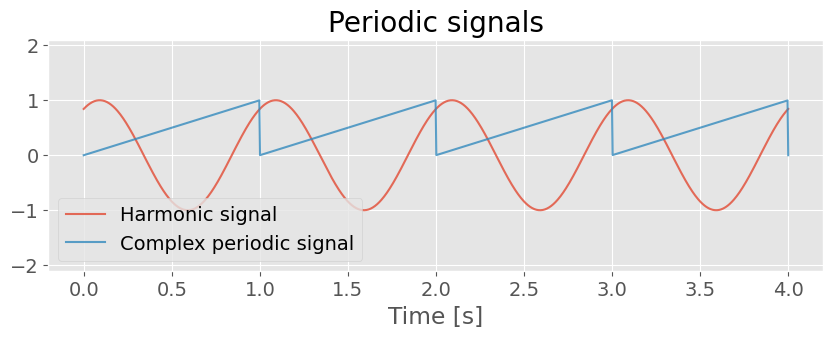

In [2]:
# Periodic Harmonic and complex periodic signals

t, dt = np.linspace(0,4,1000, retstep=True)
plt.title('Periodic signals')
plt.plot(t, np.sin(2*np.pi*t+1), label='Harmonic signal', alpha=0.8) 
plt.plot(t, t%1, label='Complex periodic signal', alpha=0.8) 
plt.ylim(-2.1,2.1)
plt.xlabel('Time [s]')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

### Example: Complex periodic and almost periodic signals

In case of ****complex periodic**** signals it is important that the ratio of the frequencies of the harmonic components is a rational number; in this case the period will repeat itself with the period of the smallest total period. If the ratio of harmonic components is not a rational number, we are talking about ****almost periodic**** signals, which belong to the group of ***non-periodic*** signals.

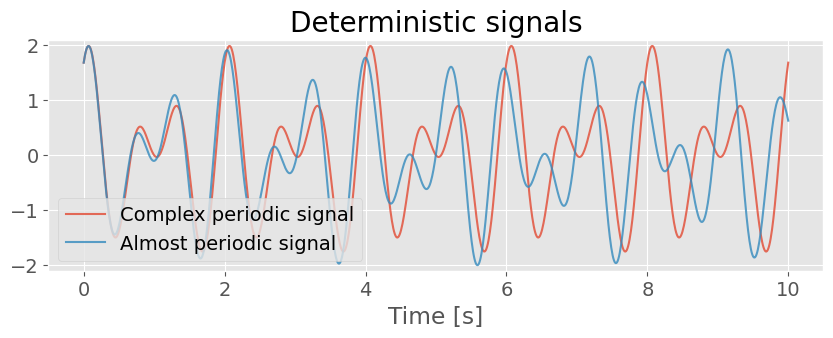

In [3]:
# Complex periodic and almost periodic signals

t, dt = np.linspace(0,10,1000, retstep=True)
plt.title('Deterministic signals')
plt.plot(t, np.sin(2*np.pi*t+1)+np.sin(3*np.pi*t+1), label='Complex periodic signal', alpha=0.8)
plt.plot(t, np.sin(2*np.pi*t+1)+np.sin(3.075*np.pi*t+1), label='Almost periodic signal', alpha=0.8)
plt.ylim(-2.1,2.1)
plt.xlabel('Time [s]')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

### Example: Non-periodic data: transient signals

***Non-periodic*** signals are divided into ****almost periodic**** signals, ****transient**** signals and ****chaotic**** signals. For chaotic signals it is considered that due to their high degree of dynamics they can only be reliably predicted for a relatively short time, after which their behavior seems increasingly random. Here this group will not be discussed in detail.

In mechanical engineering the ****transient response**** is the response of a system to a change from an equilibrium or a steady state.

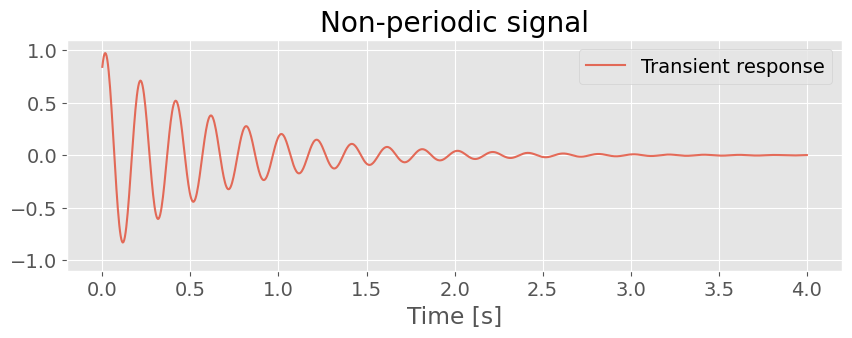

In [4]:
# Transient signal

t, dt = np.linspace(0,4,1000, retstep=True)
omega = 10*np.pi
damping = 0.05

plt.title('Non-periodic signal')
plt.plot(t, np.exp(-omega*damping*t)*np.sin(omega*t+1), label='Transient response', alpha=0.8) 
plt.ylim(-1.1,1.1)
plt.xlabel('Time [s]')
plt.grid(True)
plt.legend()
plt.show()

### Example:  Transient data - frequency sweep

For dynamic system excitation we often use a frequency sweep (or whistle); below is a 4 s long linear (monotonically increasing frequency) whistle from 1 Hz to 5 Hz.

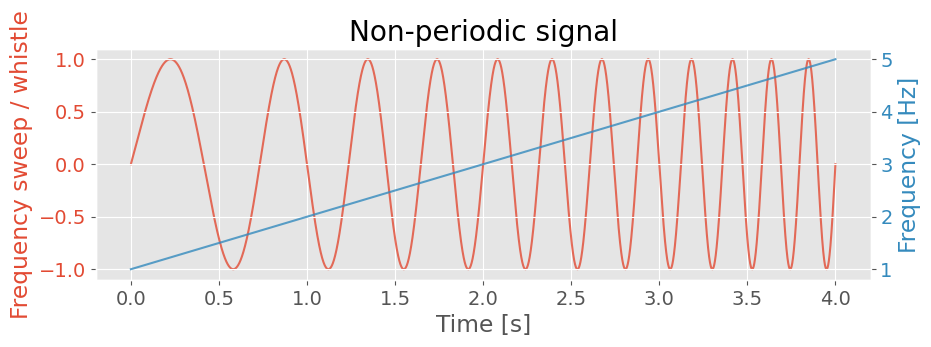

In [5]:
# frequency sweep

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
x, _, fr = es.sine_sweep(time=t, freq_start=1, freq_stop=5, mode='linear', freq_return=True)

fig, ax1 = plt.subplots()
plt.title('Non-periodic signal')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Frequency sweep / whistle', color='C0')
ax1.plot(t, x, color='C0', alpha=0.8)
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx() 
ax2.set_ylabel('Frequency [Hz]', color='C1')
ax2.plot(t, fr, color='C1', alpha=0.8) 
ax2.tick_params(axis='y', labelcolor='C1')
plt.show()


It occasionally helps us to hear the analyzed signals; below we can hear a 4 s long logarithmic whistle from 100 Hz to 16000 Hz.

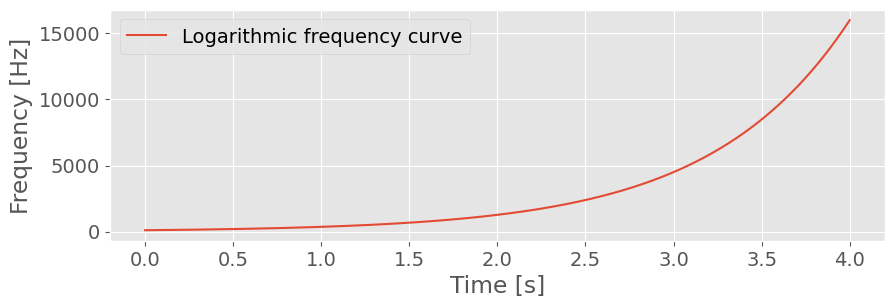

In [6]:
# frequency sweep - audio

import numpy as np
import pyExSi as es
from IPython.display import Audio, display

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
x, _, fr = es.sine_sweep(time=t, freq_start=100, freq_stop=16000, mode='logarithmic', freq_return=True)
display(Audio(data=x, rate=fs))

plt.plot(t, fr, label='Logarithmic frequency curve')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.grid(True)
plt.legend()
plt.show()

## Random data

![classification_of_data_random](./figures/classification_of_data_random.svg)

Various terminologies are used to describe these signals, namely random processes (signals), stochastic processes or time series. To describe and analyze random data probabilistic and statistical methods are required. Random signals are divided according to whether the statistical distribution that defines random data changes over time (***non-stationary***) or does not change (***stationary***).

### Example:  Random data with uniform distribution

Figure below shows random data with a uniform distribution. The left image shows the first 50 ms of data over time, and the right image shows the power spectral density (PSD; we will look at the details later). It can be observed that the uniform distribution also has a relatively constant power in the frequency domain over the entire analyzed frequency range (the data is generated with a sampling frequency of 44 kHz).

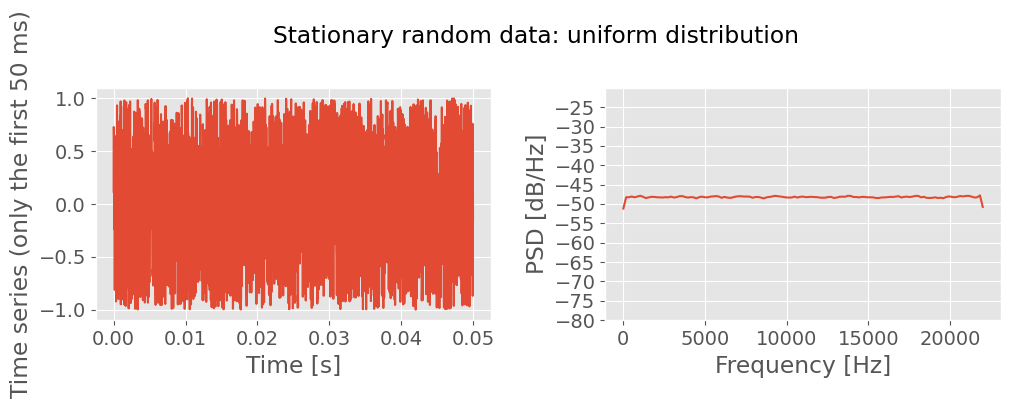

In [7]:
# Random data with uniform distribution

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
N = len(t)
x = es.uniform_random(N=N)
sel = t<0.05
display(Audio(data=x, rate=fs))


fig, axs = plt.subplots(1,2, figsize=(10,3.5))
fig.suptitle('Stationary random data: uniform distribution')
plt.tight_layout(pad=1, w_pad=3)
axs[0].plot(t[sel], x[sel])
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Time series (only the first 50 ms)')
axs[1].psd(x, Fs=fs)
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('PSD [dB/Hz]')
axs[1].set_ylim(-80, -20)
axs[1].set_yticks(np.arange(-80,-20,5))
plt.show()

### Example:  Stationary random process 

However, the above approach is rarely used for excitation of dynamical systems; instead the time series are defined using the power spectral density (PSD). The figure below shows a normally distributed random process with uniform PSD in the frequency range from 1000 Hz to 4000 Hz.

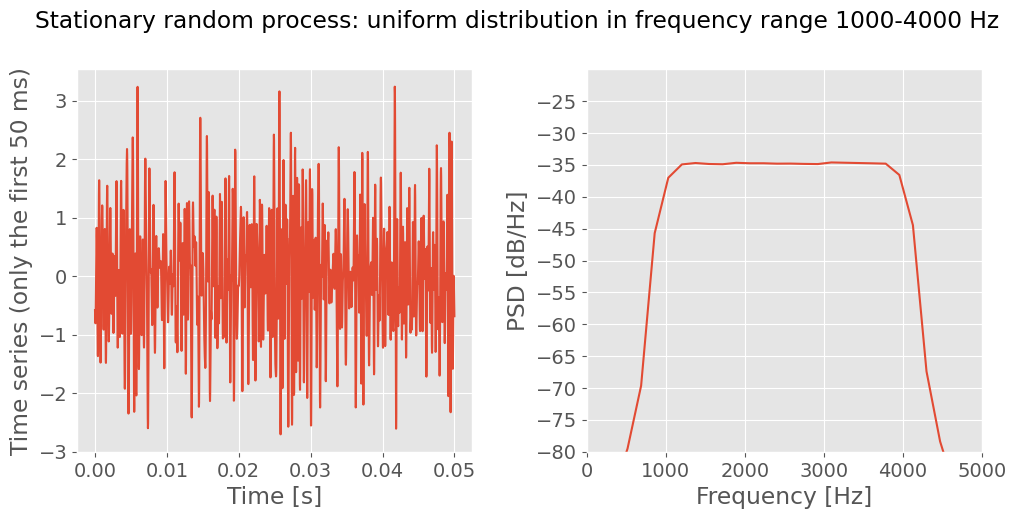

In [8]:
# Stationary random process, 1-4 kHz

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
N = len(t)

M = N // 2 + 1 # number of data points of frequency vector
freq = np.arange(0, M, 1) * fs / N # frequency vector
freq_lower = 1000 # PSD lower frequency limit  [Hz]
freq_upper = 4000 # PSD upper frequency limit [Hz]

PSD = es.get_psd(freq, freq_lower, freq_upper) # one-sided flat-shaped PSD
x = es.random_gaussian(N, PSD, fs)

sel = t<0.05
display(Audio(data=x, rate=fs))


fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.suptitle(f'Stationary random process: uniform distribution in frequency range {freq_lower}-{freq_upper} Hz')
plt.tight_layout(pad=1, w_pad=3)
axs[0].plot(t[sel], x[sel])
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Time series (only the first 50 ms)')
axs[1].psd(x, Fs=fs)
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('PSD [dB/Hz]')
axs[1].set_xlim(0, 5000)
axs[1].set_ylim(-80, -20)
axs[1].set_yticks(np.arange(-80,-20,5))
plt.show()


For comparison, the figure below shows a normally distributed random process with uniform PSD in the frequency range from 100 Hz to 400 Hz.

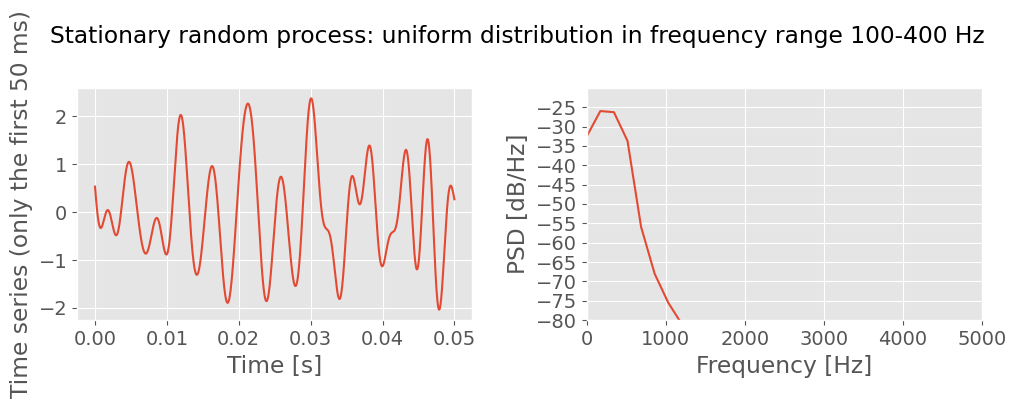

In [9]:
# Stationary random process, 100-400 Hz

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
N = len(t)

M = N // 2 + 1 # number of data points of frequency vector
freq = np.arange(0, M, 1) * fs / N # frequency vector
freq_lower = 100 # PSD lower frequency limit  [Hz]
freq_upper = 400 # PSD upper frequency limit [Hz]

PSD = es.get_psd(freq, freq_lower, freq_upper) # one-sided flat-shaped PSD
x = es.random_gaussian(N, PSD, fs)

sel = t<0.05
display(Audio(data=x, rate=fs))


fig, axs = plt.subplots(1,2, figsize=(10,3.5))
fig.suptitle(f'Stationary random process: uniform distribution in frequency range {freq_lower}-{freq_upper} Hz')
plt.tight_layout(pad=1, w_pad=3)
axs[0].plot(t[sel], x[sel])
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Time series (only the first 50 ms)')
axs[1].psd(x, Fs=fs)
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('PSD [dB/Hz]')
axs[1].set_xlim(0, 5000)
axs[1].set_ylim(-80, -20)
axs[1].set_yticks(np.arange(-80,-20,5))
plt.show()  

### Example:  Non-stationary random process 

Non-stationary random processes can not be defined with PSD, as its statistical properties changes over time. In many cases, the non-stationarity is exhibited as a power fluctuation, which ca be described by amplitude modulation of stationary process.

This example uses the stationary random process with uniform PSD in the frequency range from 1000 Hz to 4000 Hz, which is modulated by the low-frequency random process (uniform, 10-20 Hz). Despite the fact that the power density is similarly distributed as above, the non-Gaussian and non-stationary signal usually sounds significantly more unpleasant and, in the case of vibration fatigue, also significantly more detrimental to fatigue life.

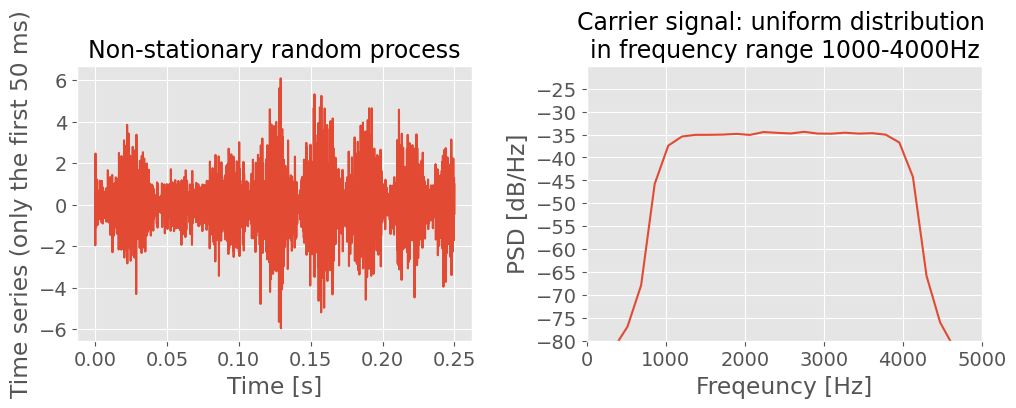

In [10]:
# Non-stationary random process 

fs = 44000
T = 2
t = np.linspace(0,T,fs*T+1)
N = len(t)

M = N // 2 + 1 # number of data points of frequency vector
freq = np.arange(0, M, 1) * fs / N # frequency vector
freq_lower = 1000 # PSD lower frequency limit  [Hz]
freq_upper = 4000 # PSD upper frequency limit [Hz]
freq_lower_mod = 10 # modulating signals's PSD lower frequency limit  [Hz]
freq_upper_mod = 20 # modulating signals's PSD upper frequency limit [Hz]

PSD = es.get_psd(freq, freq_lower, freq_upper) # one-sided flat-shaped PSD
PSD_modulating = es.get_psd(freq, freq_lower_mod, freq_upper_mod) # one-sided flat-shaped PSD

k_u = 5 # kurtosis
x = es.nonstationary_signal(N,PSD,k_u=k_u, fs=fs, modulating_signal=('PSD',PSD_modulating))

sel = t<0.25
display(Audio(data=x, rate=fs))


fig, axs = plt.subplots(1,2,  figsize=(10,3.5))
plt.tight_layout(pad=1, w_pad=3)
axs[0].set_title(f'Non-stationary random process', fontsize=17)
axs[0].plot(t[sel], x[sel])
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(f'Time series (only the first 50 ms)')
axs[1].set_title(f'Carrier signal: uniform distribution \nin frequency range {freq_lower}-{freq_upper}Hz', fontsize=17)
axs[1].psd(x, Fs=fs)
axs[1].set_xlabel('Freqeuncy [Hz]')
axs[1].set_ylabel('PSD [dB/Hz]')
axs[1].set_xlim(0, 5000)
axs[1].set_ylim(-80, -20)
axs[1].set_yticks(np.arange(-80,-20,5))
plt.show()

# Statistics and probability
<a id='Statistics_and_probability'></a>

Approaches to describe and analyze random signals require probabilistic and statistical methods. The following discusses basic probability theory:

- Probability
- Algebra of events
- Algebra of probabilities
- Random variables and probability distributions
- Cumulative Distribution Function
- Probability Density Function
- Moments of a Random Variable

## Probability

The theory of probability formalizes the representation of probabilistic concepts through a set of rules. It may be best explained by examples - games of chance, such as tossing coins, rolling dice..., 

![sample_space_event](./figures/sample_space_event.svg)

- ***An experiment of chance*** is an experiment whose outcome is not predictable
- ***The sample space*** is the collection (set) of all possible outcomes of an experiment, and is denoted by $\Omega$.
- ***An event*** is the outcome of an experiment and is the collection (subset) of points in the
sample space, and denoted by $E$

## Algebra of events

Simple ***set operations*** visualized with reference to Venn diagrams are useful in setting up the basic axioms of probability. Given events $A$, $B$, $C$, ... in a sample space $\Omega$, we can define certain operations on them which lead to other events in $\Omega$. These may be represented by Venn diagrams:

- Event $A$ and its complement $A'$

![event_complement](./figures/event_complement.svg)

- Union and intersection

![event_union_intersection](./figures/event_union_intersection.svg)

## Algebra of probabilities

The above ideas are formalized into the axioms of probability as follows. To each event $E_i$ (in a sample space $\Omega$), we assign a number called the probability of $E_i$ (denoted $P(E_i)$), such that:

- $0 \leq P(E_i) \leq 1$, where the probability of occurrence of event $E_i$ is $P(E_i) = \frac{n_{E_i}}{n_\Omega}$

- $P(\Omega) = P(\cup E_i) = 1$ and $P(\Phi)=0$

- $ P(E_i \cup E_j) =  P(E_i) + P(E_j$) if $E_i$ and $E_j$ are mutually exclusive; otherwise $P(E_i \cup E_j) =  P(E_i) + P(E_j) -
P(E_i \cap E_j)$

### Joint and Conditional Probability

The probability of occurrence of events $A$ and $B$ jointly is called a ***joint probability*** and is denoted $P(A \cap B)$ or $P(A, B)$

![event_intersection](./figures/event_intersection.svg)

$$
P(A \cap B) = \frac{n_{A \cap B}}{n_\Omega}
$$

![event_intersection](./figures/event_intersection.svg)


The probability of occurrence of an event $A$ given that event $B$ has occurred is written as $P(A|B)$, and is called a ***conditional probability***

$$
P(A|B) = \frac{P(A \cap B)}{P(B)}
$$

##  Random variables and probability distributions

In many cases it is more convenient to define the outcome of an experiment as a set of
numbers rather than the actual elements of the sample space. So we define a random variable
as a function defined on a sample space

![random_variable](./figures/random_variable.svg)

## Cumulative Distribution Function

The cumulative distribution function (CDF) of continuous random variable $X$ is the probability of a random variable $X$ taking a value less than or equal to $x$. 

![RV_CDF](./figures/RV_CDF.svg)

This is described by $F(x)$
where:

- $F(x) = P[X \leq x]$
- $F(x_2) \geq F(x_1)$ for $ x_2 \geq x_1$
- $P[a < X \leq b] =  P[X \leq b] - P[X \leq a] = F(b) - F(a)$;  for $ a < b$


## Probability Density Function

Probability density function (PDF) of a continuous random variable $X$ specify the probability of the random variable $X$ to fall within a particular range:

$$
p(x) = \lim_{\delta x \rightarrow 0} \frac{P\left[x < X \leq  x+\delta x \right]}{\delta x} =  \frac{d F(x)}{d x} 
$$

![RV_pdf](./figures/RV_pdf.svg)

Some properties of the probability density function $p(x)$ are:

- $p(x) \geq 0$
- $\int_{- \infty}^{- \infty} p(x) \mathrm{d}x = 1$
- $P[a < X \leq b] =\int_{a}^{b} p(x) \mathrm{d}x$


## Moments of a Random Variable

The probability density function $p(x)$ contains the complete information about the probability characteristics of $X$, but it is sometimes useful to summarize this information in a few numerical parameters, the so-called moments of a random variable:

- $k$-th moment: $\mu_x^k = E[X^k] = \int_{-\infty}^{\infty} x^k\,p(x)\,\mathrm{d}x$
- $k$-th central moment:$\sigma_x^k = E[(X-\mu_x)^k] = \int_{-\infty}^{\infty} (x - \mu_x)^k\,p(x)\,\mathrm{d}x$ 

The first and second moments

- First moment (***mean***): $\mu_x = E[X] = \int_{-\infty}^{\infty} x\,p(x)\,\mathrm{d}x$
- Second central moment (***variance***): $\mathrm{Var}(X) = \sigma_x^2 = E[(X-\mu_x)^2] = \int_{-\infty}^{\infty} (x - \mu_x)^2\,p(x)\,\mathrm{d}x$  

## Some well-known distributions: 

***Uniform distribution***

$$
\begin{equation}
  p(x) =
    \begin{cases}
       \frac{1}{b-a} & a \leq x \leq b\\
      0 & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

- mean: $\mu_x = \frac{a+b}{2}$

- variance: $\sigma_x^2 = \frac{(b-a)^2}{12}$

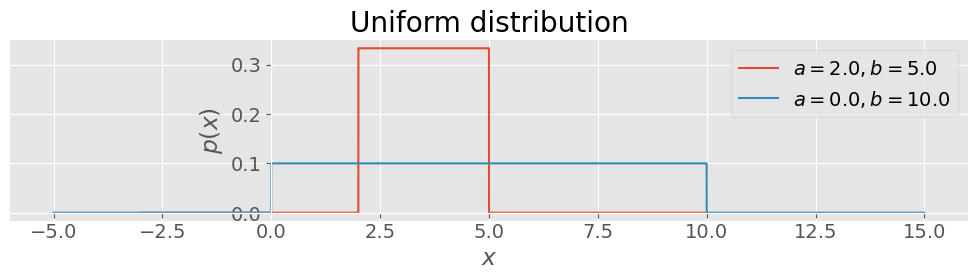

In [11]:
# Uniform distribution

import sympy as sym
from sympy.stats import Uniform, density, E, variance

a = sym.Symbol("a", positive = True)
b = sym.Symbol("b", positive = True)
x = sym.Symbol("x")


X = Uniform("x", a, b)
pdf = density(X)(x)


data={a: 2., b: 5.}
pdf1 = sym.plot(pdf.subs(data), (x, a.subs(data)-5, b.subs(data)+5), line_color='C0', 
              label=f'$a={a.subs(data):3.1f}, b={b.subs(data):3.1f}$', show=False, 
              title='Uniform distribution', ylabel='$p(x)$', xlabel='$x$')

data={a: 0., b: 10.}
pdf2 = sym.plot(pdf.subs(data), (x, a.subs(data)-5, b.subs(data)+5), line_color='C1', 
              label=f'$a={a.subs(data):3.1f}, b={b.subs(data):3.1f}$', show=False,)

pdf1.extend(pdf2)
pdf1.legend = True
pdf1.show()

In [12]:
# mean 
m1 = sym.integrate(x*pdf, (x, -sym.oo, +sym.oo)).simplify() 
m1 = m1.subs(sym.Max(a,b), b).simplify()
m1
#E(X).simplify()

a/2 + b/2

In [13]:
# variance

cm2 = sym.integrate((x-m1)**2 * pdf, (x, -sym.oo, +sym.oo)).simplify()
cm2 = cm2.subs(sym.Max(a,b), b).simplify()
cm2

#variance(X).simplify()

a**2/12 - a*b/6 + b**2/12

***Gaussian distribution (Normal distribution)***

$$
p(x; \mu_x, \sigma_x) = \frac{1}{\sigma_x\, \sqrt{2\,\pi}} \mathrm{e}^{-\frac{(x-\mu_x)^2}{2\,\sigma_x^2}}
$$

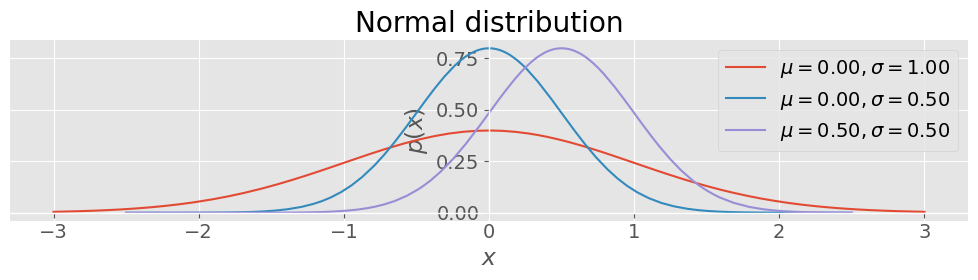

In [14]:
# Normal distribution

import sympy as sym

σ, μ, x, = sym.symbols('\sigma, \mu, x', real=True)
π = sym.pi

pdf = 1/(σ*sym.sqrt(2*π)) * sym.exp(-(x-μ)**2/(2*σ**2))

data = {σ: 1., μ: 0.}

p1 = sym.plot(pdf.subs(data), (x, -3*σ.subs(data), +3*σ.subs(data)), line_color='C0', 
              label=f'$\\mu={μ.subs(data):3.2f}, \\sigma={σ.subs(data):3.2f}$', show=False, 
              title='Normal distribution', ylabel='$p(x)$', xlabel='$x$')

data = {σ: 0.5, μ: 0.}
p2 = sym.plot(pdf.subs(data), (x, -5*σ.subs(data), +5*σ.subs(data)), line_color='C1', 
              label=f'$\\mu={μ.subs(data):3.2f}, \\sigma={σ.subs(data):3.2f}$', show=False)
data = {σ: 0.5, μ: 0.5}
p3 = sym.plot(pdf.subs(data), (x, -5*σ.subs(data), +5*σ.subs(data)), line_color='C2', 
              label=f'$\\mu={μ.subs(data):3.2f}, \\sigma={σ.subs(data):3.2f}$', show=False)

p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()

In [15]:
# mean

σ, μ, x, = sym.symbols('\sigma, \mu, x', real=True, positive=True)
π = sym.pi
pdf = 1/(σ*sym.sqrt(2*π)) * sym.exp(-(x-μ)**2/(2*σ**2))
m1 = sym.integrate(x*pdf, (x, -sym.oo, +sym.oo))
m1 

\mu

In [16]:
# variance
cm2 = sym.integrate((x-μ)**2 * pdf, (x, -sym.oo, +sym.oo))
cm2

\sigma**2

# Gaussian, random and stationary time series
<a id='Gaussian_random_and_stationary_time_series'></a>

The Gaussian distribution is probably the most important distribution, since many practical processes can be approximated as Gaussian due to the ***central limit theorem***.

### Example: Central limit theorem

The importance of the Gaussian distribution is illustrated by a particular property: let $X_1$, $X_2$, ..., $X_k$, ..., $X_n$ be independent random variables that have their own probability distributions; then the sum of random variables, $S_n = \sum_{k=1}^n X_k$, tends to have a Gaussian distribution as $n$ gets large, regardless of their individual distribution of $X_k$. This is a version of the so-called central limit theorem.

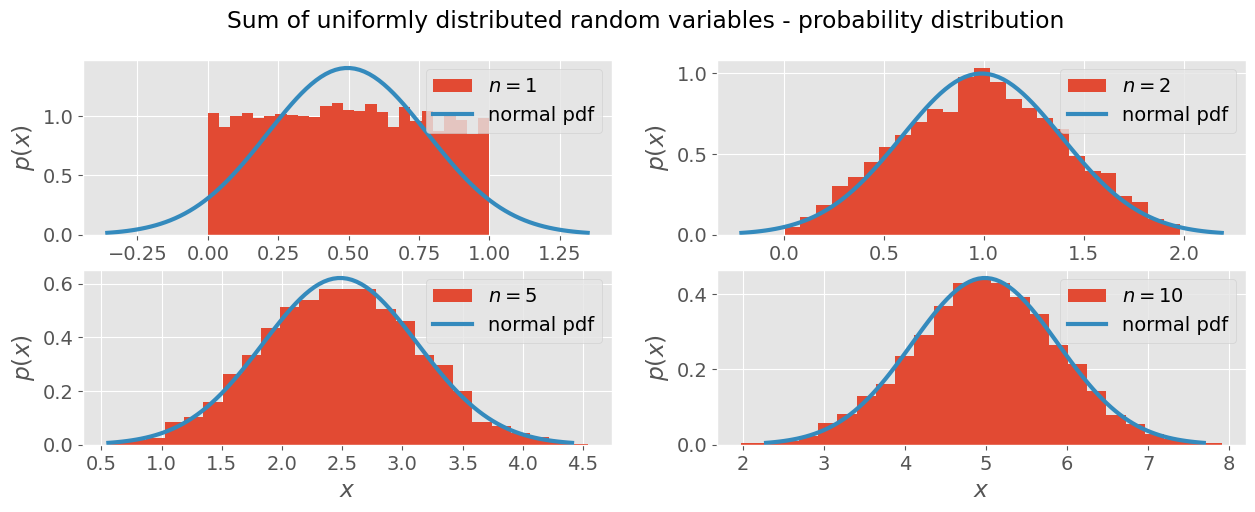

In [17]:
# Central limit theorem

import numpy as np

seed = 123
rng = np.random.default_rng(seed)
N = 10 # Number of random variables
data = [rng.uniform(low=0, high=1, size=5000) for i in range(N)] # N random data, each containing 5000 points 

# summation, for n=1,2,5 and 10
S1 = np.sum(data[:1], axis=0) # n=1
S2 = np.sum(data[:2], axis=0) # n=2
S5 = np.sum(data[:5], axis=0) # n=5
S10 = np.sum(data[:10], axis=0) #n=10

σ, μ, x, = sym.symbols('\sigma, \mu, x', real=True, positive=True)
π = sym.pi
p = 1/(σ*sym.sqrt(2*π)) * sym.exp(-(x-μ)**2/(2*σ**2)) #Theoretical pdf

fig, axs = plt.subplots(2,2, figsize=(15,5))
fig.suptitle(r'Sum of uniformly distributed random variables - probability distribution')
bins = 25 # number of bins for histogram

axs[0,0].hist(S1, bins=bins, density=True, label='$n=1$');
data = {σ: np.std(S1), μ: np.mean(S1)}
pdf = sym.lambdify(x, p.subs(data))
x_S1 = np.linspace(-3*data[σ]+data[μ],3*data[σ]+data[μ], 100)
axs[0,0].plot(x_S1, pdf(x_S1), lw=3, label='normal pdf')
axs[0,0].set_ylabel('$p(x)$')
axs[0,0].legend(loc='upper right')

axs[0,1].hist(S2, bins=bins, density=True, label='$n=2$');
data = {σ: np.std(S2), μ: np.mean(S2)}
pdf = sym.lambdify(x, p.subs(data))
x_S2 = np.linspace(-3*data[σ]+data[μ],3*data[σ]+data[μ], 100)
axs[0,1].plot(x_S2, pdf(x_S2), lw=3, label='normal pdf')
axs[0,1].set_ylabel('$p(x)$')
axs[0,1].legend(loc='upper right')

axs[1,0].hist(S5, bins=bins, density=True, label='$n=5$');
data = {σ: np.std(S5), μ: np.mean(S5)}
pdf = sym.lambdify(x, p.subs(data))
x_S5 = np.linspace(-3*data[σ]+data[μ],3*data[σ]+data[μ], 100)
axs[1,0].plot(x_S5, pdf(x_S5), lw=3, label='normal pdf')
axs[1,0].set_xlabel('$x$')
axs[1,0].set_ylabel('$p(x)$')
axs[1,0].legend(loc='upper right')

axs[1,1].hist(S10, bins=bins, density=True, label='$n=10$');
data = {σ: np.std(S10), μ: np.mean(S10)}
pdf = sym.lambdify(x, p.subs(data))
x_S10 = np.linspace(-3*data[σ]+data[μ],3*data[σ]+data[μ], 100)
axs[1,1].plot(x_S10, pdf(x_S10), lw=3, label='normal pdf')
axs[1,1].set_xlabel('$x$')
axs[1,1].set_ylabel('$p(x)$')
axs[1,1].legend(loc='upper right');

## Stohastic random process

A random process is defined through a combination of the amplitude probability density function (PDF) function and the power spectral density (PSD). The definition, in a very broad sense, corresponds to an ensemble $\left\{x_k(t)\right\}$ of sample functions (observations) $x_k(t)$; the animation below shows an ensemble of observations, where observation $k$ consisting of a random variable at time $t_i: x_k(t_i)$.

<IPython.core.display.Javascript object>


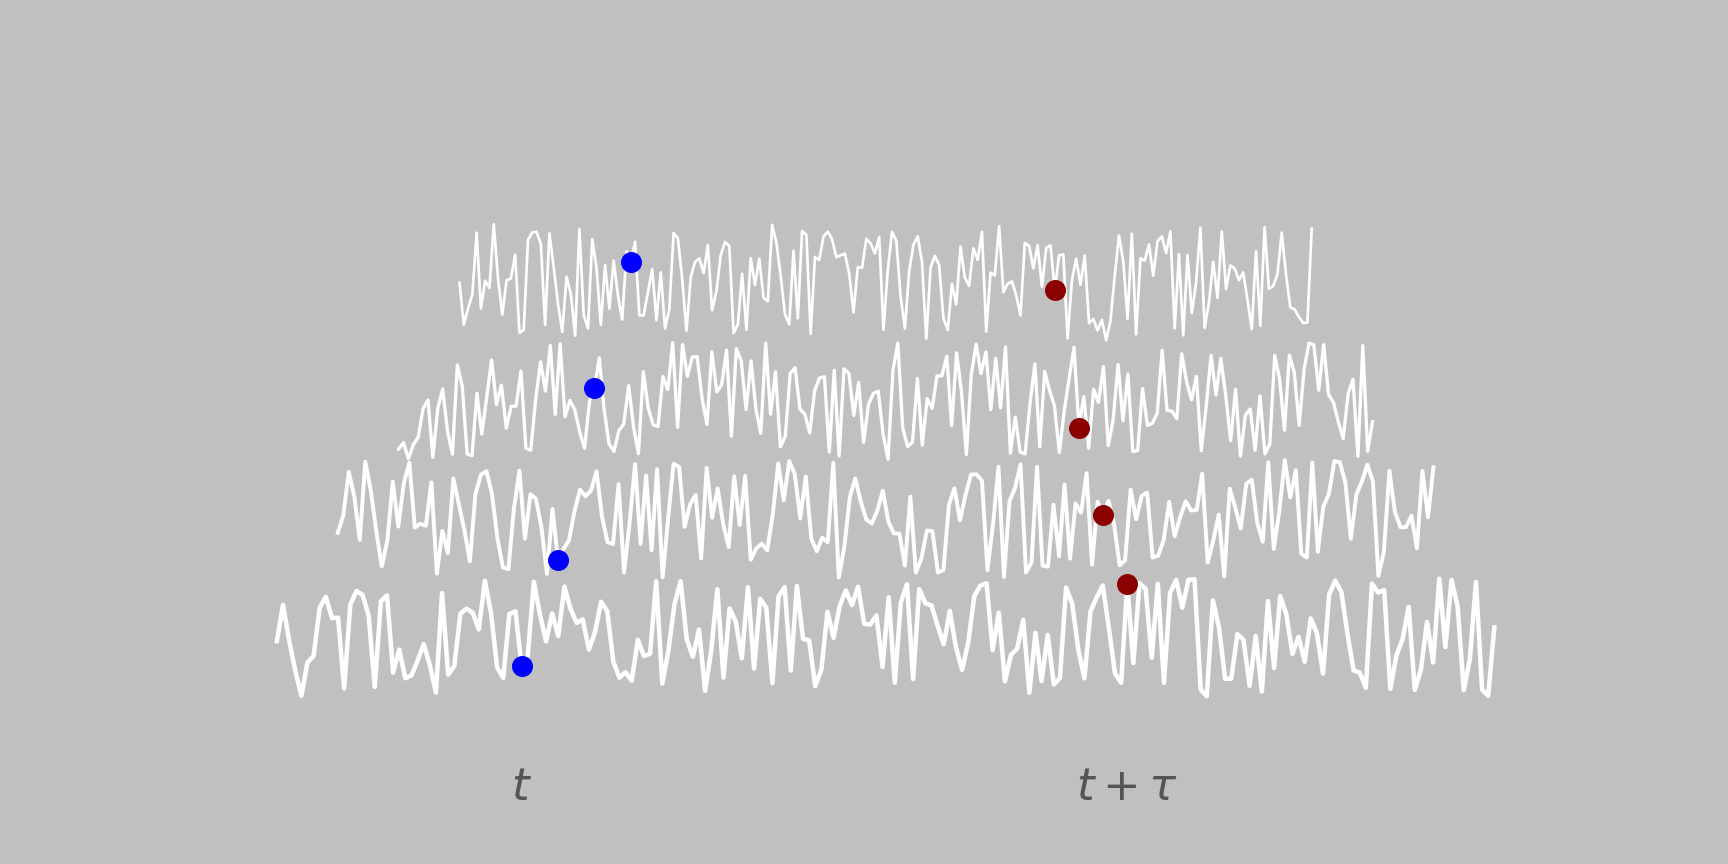

C:\Users\janko\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [68]:
# Ensenble of sample functions 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib notebook 

# Fixing random state for reproducibility
np.random.seed(19680801)

# Create new Figure with black background
fig = plt.figure(figsize=(8, 4), facecolor='silver')

# Add a subplot with no frame
ax = plt.subplot(frameon=False)

# Generate random data
N = 4 #nuber of random processes
n = 200 # data points 
data = np.random.uniform(0, 1, (N, n))
X = np.linspace(-1, 1, data.shape[-1])
t_obs = -.6  # time interval [-1,1]
tau = 1
t_indx = np.argmin(np.abs(X-t_obs))
tau_indx = np.argmin(np.abs(X-(t_obs+tau)))

# Generate line plots
lines = []
for i in range(len(data)):
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - i / 10.
    # Same for linewidth (thicker strokes on bottom)
    lw = 1.5 - i / 5.0
    line_data, = ax.plot(xscale * X, i + data[i], color="w", lw=lw)
    line_t, = ax.plot(xscale * X[t_indx], i + data[i][t_indx] , 'o', color='blue')
    line_ttau, = ax.plot(xscale * X[tau_indx], i + data[i][tau_indx] , 'o', color='darkred')
    lines.append(line_data)
    lines.append(line_t)
    lines.append(line_ttau)

# Set y limit (or first line is cropped because of thickness)
ax.set_ylim(-.5, 5)

#ticks
ax.grid(False)
ax.set_xticks([X[t_indx],X[tau_indx]], ['$t$','$t+\\tau$'])
ax.tick_params(axis='x', length=0, labelsize=15)
ax.set_yticks([]) # no labels


def update(*args):
    # Shift all data to the right
    data[:, 1:] = data[:, :-1]

    # Fill-in new values
    data[:, 0] = np.random.uniform(0, 1, len(data))

    # Update data
    for i in range(len(data)):
        lines[3*i].set_ydata(i + data[i])
        lines[3*i+1].set_ydata(i + data[i][t_indx])
        lines[3*i+2].set_ydata(i + data[i][tau_indx])

    # Return modified artists
    return lines

# Construct the animation, using the update function as the animation director.
anim = animation.FuncAnimation(fig, update, interval=100)
plt.show()

## Probability distribution

- Cumulative Distribution Function: $F(x, t) = P[X(t) \leq x]$

- Probability Density Function: $f(x, t) =  \frac{d F(x, t)}{d x} $

![RP_pdf](./figures/RP_pdf.svg)

In general, the PDF and CDF for a stochastic process are time dependent.

## Moments of a stohastic process


- First moment (***mean***): $\mu_x(t) = E[X(t)] = \int_{-\infty}^{\infty} x\,p(x,t)\,\mathrm{d}x$
- Second moment (***mean square***):  $E[X^2(t)] = \int_{-\infty}^{\infty} x^2(t)\,p(x,t)\,\mathrm{d}x$
- Second central moment (***variance***): $\mathrm{Var}(X(t)) = \sigma_x^2(t) = E[(X(t)-\mu_x(t))^2] = \int_{-\infty}^{\infty} (x - \mu_x(t))^2\,p(x,t)\,\mathrm{d}x$

## Stationarity

As we have seen previously, the probability properties of a stochastic process vary with time. It is often assumed that those statistical properties are time-independent:

- mean and variance are constant:

$$
p(x,t) = p(x) \rightarrow \mu_x(t) = \mu_x \quad \mathrm{and} \quad \sigma_x^2(t) = \sigma_x^2
$$

- Joint distributions $p(x_1, t_1; x_2, t_2)$ is a function of time difference $(t_2-t_1)$ only, and does not explicitly depend on individual times $t_1$ and $t_2$:

$$
p(x_1, t_1; x_2, t_2) = p(x_1, t_1 + T; x_2, t_2+T)
$$



If a process satisfies those two conditions it is ***weakly stationary*** (or simply stationary).

A random process for which all joint distributions are invariant to shifts in time is called ***strictly stationary***:

- $p(x_1, t_1; x_2, t_2;...,;x_k, t_k) = p(x_1, t_1 + T; x_2, t_2+T;...; x_k, t_k+T)$

## The  Autocovariance and Autocorrelation Functions

A simple generalization of the variance of the random process, $\sigma_x^2(t) = E[(X(t)-\mu_x(t))^2]$, introduces the ***autocovariance function*** as

$$
C_{xx}(t_1, t_2) = E \big{[}[X(t_1) - \mu_x(t_1)] \, [X(t_2) - \mu_x(t_2)]\big{]}
$$

Under assumption of stationarity, the autocovariance function is a function of time difference $\tau$ only

$$
C_{xx}(\tau)  =  C_{xx}(t, t + \tau) = E \big{[}[X(t) - \mu_x] \, [X(t+\tau) - \mu_x]\big{]}
$$

Note that when $\tau=0$, the $C_{xx}(0) = E \big{[}[x(t) - \mu_x]^2\big{]}= \sigma_x^2$

For a zero-mean stationary process, $\mu_x=0$, the autocovariance function equals the ***autocorrelation function***

$$
R_{xx}(\tau) = E[ x(t) \, x(t+\tau)]
$$

with their relationship being

$$
C_{xx}(\tau) = R_{xx}(\tau) - \mu_x^2
$$

### Example: Autocorrelation function of a sine wave

Considering sinusoidal signal $x(t) = A \mathrm{sin}(\omega\,t + \phi)$, the theoretical autocorrelation functions is

$$
R_{xx}(\tau) = \frac{A^2}{2} \mathrm{cos}(\omega\,\tau)
$$
 
Assuming the random variable $\phi$, the autocorrelation function is obtained via ensemble average at time $t$.

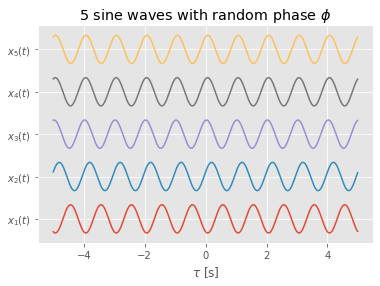

In [19]:
# Autocorrelation function of a sine wave

%matplotlib inline

A = 1 #amlitude
f0 = 1 #frequency
omega = 2 * np.pi * f0
fs = 100 # sampling frequency
t0 = 0 # observation time t

max_lag_s = 5 # observation time is t0+-5 seconds
tau = np.arange(-max_lag_s, +max_lag_s, 1/fs) #observation time

seed = 123
rg =  np.random.default_rng(seed)
N = 1000 #size of ensemble
theta = rg.random(N) * 2*np.pi #random phase from 0-2pi
data = [A*np.sin(omega*tau+theta_i) for theta_i in theta]  # sine waves with random phases

#plot firt 5 random processes
fig, ax= plt.subplots()
plt.title('5 sine waves with random phase $\phi$')
y_ticks = []
for n in range(5):
    signal_offset = 3*n*A
    ax.plot(tau, data[n] + signal_offset)
    y_ticks.append(signal_offset)
    
ax.set_yticks(y_ticks, labels=[f'$x_{i+1:g}(t)$' for i in range(5)])
ax.set_xlabel('$\\tau$ [s]');

For the $n$-th record, we form $X_n(t)X_n(t + \tau)$ and average this product over all observations, i.e. an ensemble average.

$$
R_{xx}(\tau) = E[ x(t) \, x(t+\tau)] = \lim_{N\rightarrow \infty}\frac{1}{N}\left[ \sum_{n=1}^{N} X_n(t)X_n(t+\tau) \right]
$$

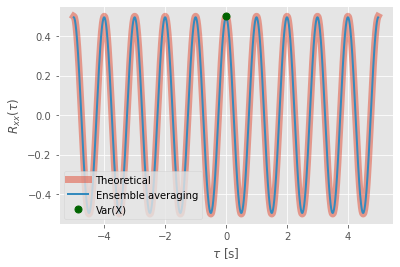

In [20]:
# Autocorrelation function of a sine wave

# theoretical value
Rxx = A**2/2*np.cos(omega*tau)

# Ensemble averaging
x0 = A*np.sin(omega*t0+theta) #  value at t0
Rxx1 = [] 
for tau_i in tau:
    tmp = A*np.sin(omega*(t0+tau_i)+theta) # value of sine at t0+tau_i
    tmp = x0 * tmp 
    Rxx1.append(tmp)
    
Rxx1 = np.array(Rxx1)
Rxx1 = Rxx1.mean(axis=1) #averaging over phase


var = A**2/2 # Rxx(0) = var

plt.plot(tau, Rxx, lw=7, alpha=.5, label='Theoretical')
plt.plot(tau, Rxx1, lw=2, label='Ensemble averaging')
plt.plot(0,var, 'o', ms=7, color='darkgreen', label='Var(X)')
plt.legend(loc='lower left')
plt.xlabel('$\\tau$ [s]')
plt.ylabel('$R_{xx}(\\tau)$');

## The  Cross-covariance and Cross-correlation Functions

Considering two stochastic processes $\left\{X(t)\right\}$ and $\left\{Y (t)\right\}$ simultaneously, e.g. an input-output process, the cross-covariance function is defined as

$$
C_{xy}(t_1, t_2) = E \big{[}[X(t_1) - \mu_x(t_1)] \, [Y(t_2) - \mu_y(t_2)]\big{]}
$$

If we assume both signals are stationary then $C_{xy}(t_1, t_2)$ is a function of time difference $\tau$

$$
C_{xy}(\tau)  =  C_{xy}(t, t + \tau) = E \big{[}[X(t) - \mu_x] \, [Y(t+\tau) - \mu_y]\big{]}
$$

For a zero-mean stationary process, $\mu_x=0$, the cross-covariance function equals the ***cross-correlation function***

$$
R_{xy}(\tau) = E[ X(t) \, Y(t+\tau)]
$$

with their relationship being

$$
C_{xy}(\tau) = R_{xy}(\tau) - \mu_x\,\mu_y
$$

## Ergodicity

In many situations, we have to deal with only a single record of data rather than a set of records. In such a case, we cannot perform the average across the ensemble, but we may average along time, i.e. we perform a time average instead of ensemble average. By implication, stationarity is a necessary condition for the time average to be meaningful. 

For ergodic processes the time averages along one record  $k$ give the same results as an ensemble average. Stationary processes are ergodic with respect to the mean and covariance functions

$$
\mu_x = \mu_x(k) = \lim_{T \to \infty} \frac{1}{T}\int_{0}^{T} x_k(t)\, \textrm{d}t \quad
$$

$$
\begin{split}
C_{xx}(\tau) &= C_{xx}(\tau, k) = \lim_{T \to \infty} \frac{1}{T} \int_{0}^{T} \left[x_k(t)-\mu_x(k)\right] \, \left[x_k(t+\tau) - \mu_x(k)\right] \textrm{d}  t \\
&= R_{xx}(\tau, k) - \mu_x^2(k), \\
C_{xy}(\tau) &= C_{xy}(\tau, k) = \lim_{T \to \infty} \frac{1}{T} \int_{0}^{T} \left[x_k(t)-\mu_x(k)\right] \, \left[y_k(t+\tau) - \mu_y(k)\right] \textrm{d}  t \\
&= R_{xy}(\tau, k) - \mu_x(k) \, \mu_y(k). \\
\end{split}
$$

### Example: Ergodicity with respect to  autocorrelation function

As in previous example, considering sinusoidal signal $x(t) = A \mathrm{sin}(\omega\,t + \phi)$, the theoretical autocorrelation functions is

$$
R_{xx}(\tau) = \frac{A^2}{2} \mathrm{cos}(\omega\,\tau)
$$
 
Assuming the random variable $\phi$, the autocorrelation function is obtained via ensemble average at time $t$. For the time average $\phi$ is fixed and $t$ is a time variable.


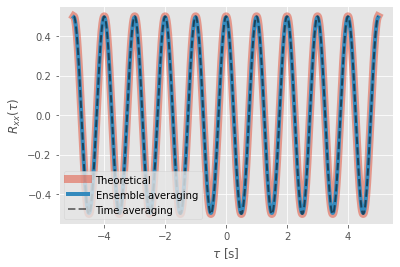

In [21]:
# Ergodicity

import pandas as pd

A = 1 #amlitude
f0 = 1 #frequency
omega = 2 * np.pi * f0
fs = 100 # sampling frequency
t0 = 0 # observation time t

seed = 123
rg =  np.random.default_rng(seed)
N = 1000 #size of ensemble
theta = rg.random(N) * 2*np.pi #random phase from 0-2pi
x0 = A*np.sin(omega*t0+theta) #  values at t0


# theoretical value
max_lag_s = 5 # observation time is t0+-5 seconds
tau = np.arange(-max_lag_s, +max_lag_s, 1/fs) #observation time
Rxx = A**2/2*np.cos(omega*tau)


# Ensemble averaging
Rxx1 = [] 
for tau_i in tau:
    tmp = A*np.sin(omega*(t0+tau_i)+theta) # value of sine at t0+tau_i
    tmp = x0 * tmp 
    Rxx1.append(tmp)
    
Rxx1 = np.array(Rxx1)
Rxx1 = Rxx1.mean(axis=1) #averaging over phase


# Time averaging
t = np.arange(0, 20, 1/fs)
x_t = A*np.sin(omega*t)
# pandas.Series.autocorr calculates Pearson correlation between the Series and its shifted self,  values in [-1, 1]
Rxx2 = [A**2/2 * pd.Series(x_t).autocorr(n) for n in range(len(tau))]  # Rxx(0)=Var(X) = A**2/2, ZAMENJATI z np.corrcoef()

plt.plot(tau, Rxx, lw=8, alpha=.5, label='Theoretical')
plt.plot(tau, Rxx1, lw=4, label='Ensemble averaging')
plt.plot(tau, Rxx2,  'k--', lw=2, alpha=.5, label='Time averaging')

plt.legend(loc='lower left')
plt.xlabel('$\\tau$ [s]')
plt.ylabel('$R_{xx}(\\tau)$');

# PSD and Cross PSD
<a id='PSD_and_Cross_PSD'></a>

The power spectral density (PSD) describes the power frequency density of a random process and complements the probability density function $p(x)$ in the definition of a particular random process; the same probability density can have very different power spectral densities (PSDs) in the frequency domain. The PSD is usually obtained by Fourier transformation, usually using the FFT algorithm.

## Fourier series

 
Fourier series is used to represent arbitrary (periodic) data by the sum of harmonic functions. The frequency of each sine and cosine wave is an integer multiple of the periodic function's fundamental frequency, i.e. $1/T_p$


![fourier_transform](./figures/fourier_transform.svg)



Representation of complex periodic function with real coefficients:


$$
\begin{split}
x(t)&=\frac{a_0}{2}+\sum_{n=1}^{N}
a_n\,\cos(2\pi\,n\,t/T_p)+
b_n\,\sin(2\pi\,n\,t/T_p)\\
a_n &= \frac{1}{T_p}\,\int_0^{T_p} x(t)\,\cos(2\pi\,n\,t/T_p)\,\mathrm{d}t\\
b_n &= \frac{1}{T_p}\,\int_0^{T_p} x(t)\,\sin(2\pi\,n\,t/T_p)\,\mathrm{d}t
\end{split}
$$

Representation of complex periodic function with complex coefficients:

$$\begin{split}
x(t)&=\sum_{n=-N}^{N}
c_n\,e^{\mathrm{i}\,2\pi\,n\,t/T_p},\qquad c_n=c_{-n}^* \\
c_n &= \frac{1}{T_p}\,\int_0^{T_p} x(t)\,e^{-\mathrm{i}\,2\pi\,n\,t/T_p}\,\mathrm{d}t
\end{split}
$$


### Example: Reconstruction of complex periodic function, defined by Fourier coefficients

<IPython.core.display.Javascript object>


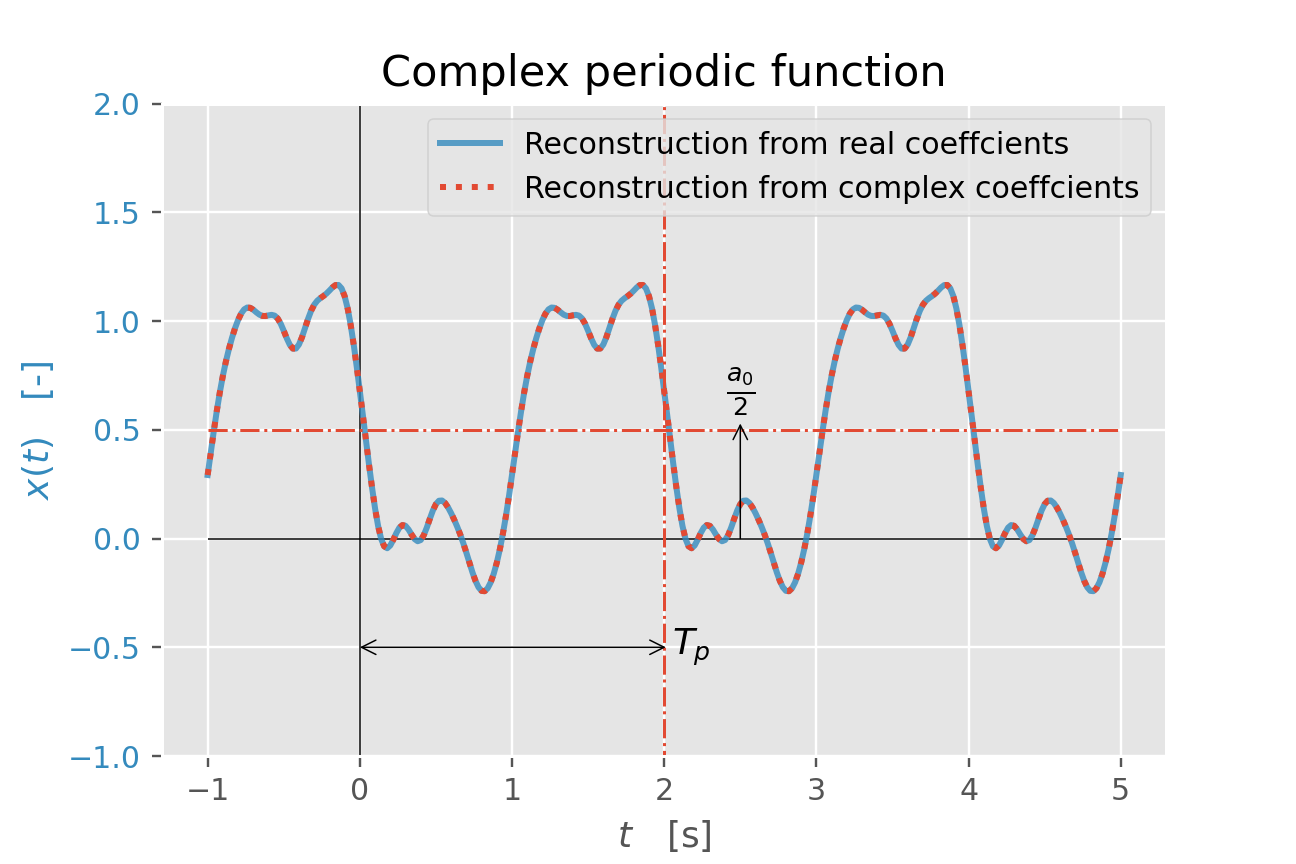

In [70]:
# Reconstruction of complex periodic function, defined by Fourier coefficients

import numpy as np
import matplotlib.pyplot as plt

Tp = 2
t, dt = np.linspace(-0.5*Tp,2.5*Tp,301, retstep=True)
a0 = 1.
N = 10
seed = 0
rg = np.random.default_rng(seed)
a = rg.normal(size=N)*1/np.arange(1,N+1)**2 # set Fourier coefficients
b = rg.normal(size=N)*1/np.arange(1,N+1)**2

# Coeffiecients in complex form 
c = np.zeros(2*N+1, dtype='complex')
c[N+1:] = 0.5*a-0.5j*b
c[N] = a0/2
c[:N] = np.conj(c[N+1:])[::-1]

# Function reconstruction, real coefficients
x1 = a0/2
for n in range(N):
    x1 += a[n]*np.cos(2*np.pi*(n+1)*t/Tp) + b[n]*np.sin(2*np.pi*(n+1)*t/Tp)

# Function reconstruction, complex coefficients    
x = np.zeros(len(t), 'complex')
for n in range(-N,N+1):
    x += c[N+n]*np.exp(2j*np.pi*n*t/Tp)
x = np.real(x) #  the imaginary part must be at the level of the numerical error
    
fig, ax1 = plt.subplots()
plt.title(f'Complex periodic function')

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
ax1.vlines(0, -2, 2, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, x1, label='Reconstruction from real coeffcients', c='C1', lw=2, alpha=0.8) 
ax1.plot(t, x, label='Reconstruction from complex coeffcients', c='C0', ls=':', lw=2, alpha=1) 
ax1.vlines([Tp], -2, 2, ls='-.', lw=1)
ax1.hlines(a0/2, np.min(t), np.max(t), ls='-.', lw=1)
ax1.annotate('$\\frac{a_0}{2}$',
            xy=(2.5, 0), xycoords='data',
            ha='center', size='large',
            xytext=(2.5, a0/2+.13), textcoords='data',
            arrowprops=dict(arrowstyle='<-',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.annotate('$T_{p}$',
            xy=(0, -0.5), xycoords='data',
            va='center', size='large', 
            xytext=(Tp+0.05, -0.5), textcoords='data',
            arrowprops=dict(arrowstyle='<->',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.legend(loc=1)
plt.ylim(-1,2)
plt.show()

### Example: Fourier coefficients -  amplitude and phase information

Fourier coefficients represent amplitude and phase information about a certain harmonic component. Let's look at an example of a periodic square wave

<IPython.core.display.Javascript object>


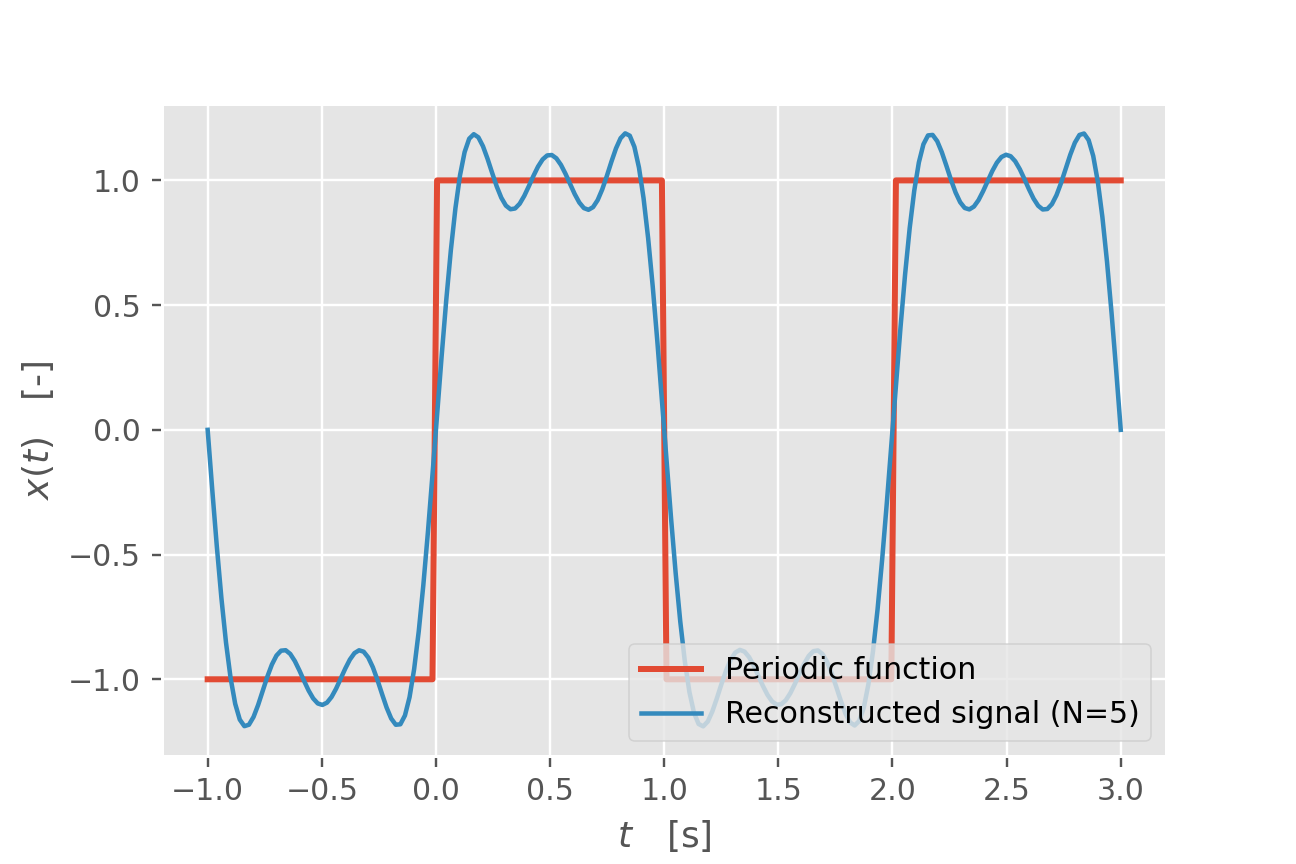

In [71]:
# Fourier coefficients -  amplitude and phase information

import numpy as np
import matplotlib.pyplot as plt

# signal
T_p = 2
n = 200
x = np.ones(n)
x[:n//4] = -1.
x[n//4:2*n//4] = 1.
x[2*n//4:3*n//4] = -1.
x[3*n//4:n] = 1.

t = np.arange(n)*2*T_p/(n-1) - T_p/2
dt = t[1]-t[0]

# Fourier series
N = 5
c = np.zeros(2*N+1, dtype='complex')
n = np.arange(-N,N+1)
# considering only one period, otherwise the coefficients are not calculated correctly
sel = np.logical_and(t>=0,t<=T_p) 
for i in n:
    c[i+N] = np.trapz(x[sel]*np.exp(-2j*np.pi*i*t[sel]/T_p), dx=dt)/T_p

# reconstruction
x_r = np.zeros(len(t), 'complex')
for _ in range(-N,N+1):
    x_r += c[N+_]*np.exp(2j*np.pi*_*t/T_p)
x_r = np.real(x_r) 

fig, ax1 = plt.subplots()

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]')
ax1.tick_params(axis='y')
ax1.plot(t, x, label='Periodic function', c='C0', lw=2, alpha=1) 
ax1.plot(t, x_r, label=f'Reconstructed signal (N={N:g})', c='C1', alpha=1) 
ax1.legend(loc=4)
plt.show()

<IPython.core.display.Javascript object>


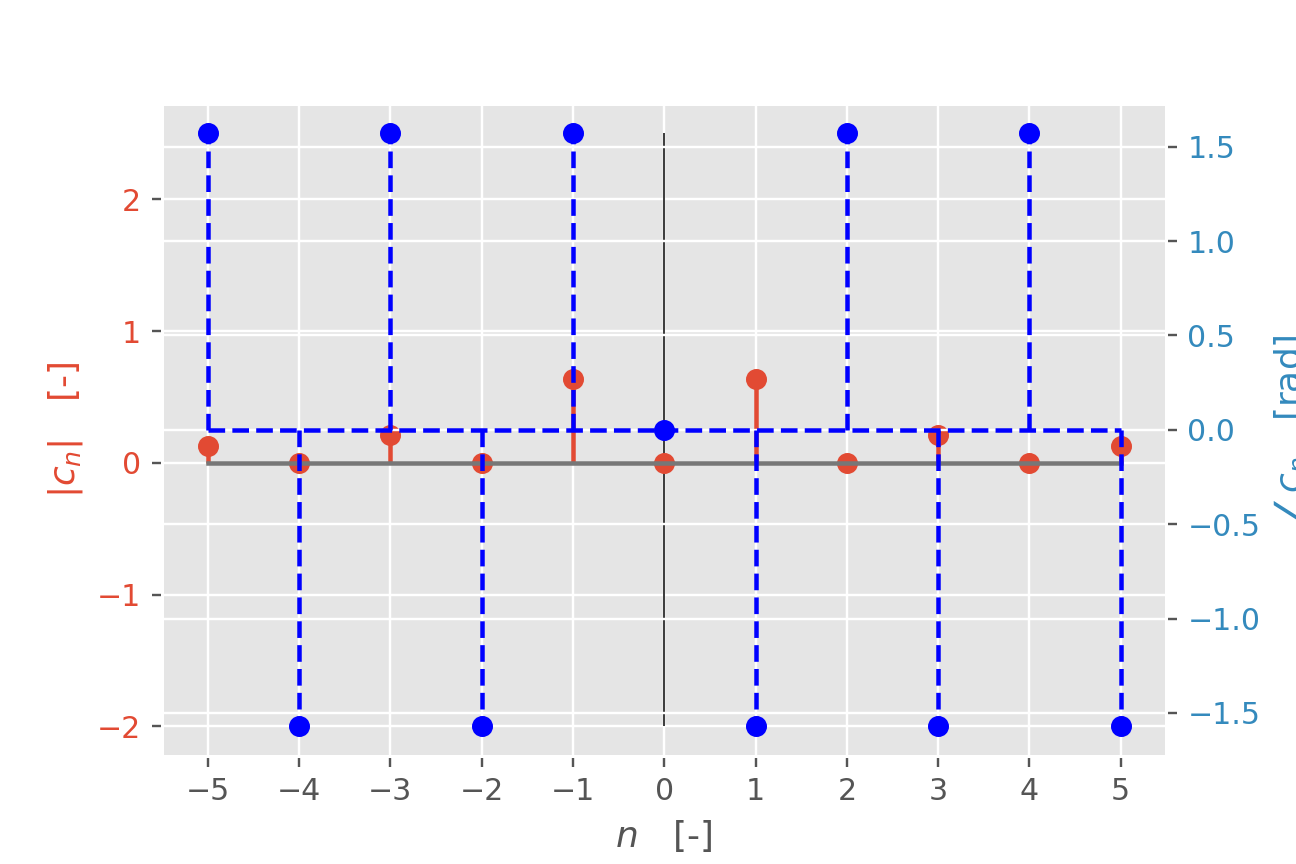

In [72]:
# Fourier coefficients -  amplitude and phase information

import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel('$n\\quad $[-]')
ax1.set_ylabel('$|c_n|\\quad$[-]', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.vlines(0, -2, 2.5, 'k', lw=0.5)
ax1.hlines(0, np.min(n), np.max(n), 'k', lw=0.5)
ax1.stem(n, np.abs(c), markerfmt = 'o', label='Amplituda $c_n$') 
ax1.set_xticks(ticks=n)

ax2 = ax1.twinx() 
ax2.stem(n, np.angle(c), markerfmt='bo', linefmt='b--', basefmt='b--', label='Faza $c_n$') 
ax2.set_ylabel('$\\angle c_n \quad$[rad]', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
plt.show()

## Parseval's Theorem

Parseval's theorem states that the sum (or integral) of the square of a function is equal to the sum (or integral) of the square of its Fourier transform

$$
\frac{1}{T_p}\int_0^{T_p}x^2(t)\,\textrm{d}t=
\sum_{n=-\infty}^{\infty}c_n\,c_n^*,
$$

### Example: Parseval Theorem

In this example the signals is reconstructed based on the Fourier coefficients, then power of the signal is calculated in time and frequency domain.

In [25]:
# Parseval Theorem

T_p = 2
t, dt = np.linspace(0,T_p,101, retstep=True)
a0 = 1.
N = 10
seed = 0
rg = np.random.default_rng(seed)
a = rg.normal(size=N)*1/np.arange(1,N+1)**2 # set Fourier coefficients
b = rg.normal(size=N)*1/np.arange(1,N+1)**2
c = np.zeros(2*N+1, dtype='complex')
c[N+1:] = 0.5*a-0.5j*b # from real to complex
c[N] = a0/2
c[:N] = np.conj(c[N+1:])[::-1]

# Signal reconstruction
x = np.zeros(len(t), 'complex')
for n in range(-N,N+1):
    x += c[N+n]*np.exp(2j*np.pi*n*t/T_p)
x = np.real(x) # the imaginary part must be at the level of the numerical error)

print(f"Signal's power, time domain: {np.trapz(x**2,dx=dt)/T_p:.4f}" + 
      f"\nSignal's power, frequency domain: {np.dot(c,np.conjugate(c)):.4f}")

Signal's power, time domain: 0.4912
Signal's power, frequency domain: 0.4912+0.0000j


## Fourier transform

Fourier transform (FT) extends the Fourier analysis to non-periodic phenomena:

***Fourier transform***

$$
X(\omega)=\mathcal{F}\{x(t)\}=\int_{-\infty}^{+\infty} x(t)\,e^{-\,\textrm{i}\,\omega\,t}\,\textrm{d} t,
\qquad
X(f)=\mathcal{F}\{x(t)\}=\int_{-\infty}^{+\infty} x(t)\,e^{-\textrm{i}\,2\pi\,f\,t}\,\textrm{d} t
$$

***Inverse Fourier transform***

$$
x(t)=\mathcal{F}^{-1}\{X(\omega)\}=\frac{1}{2\,\pi}\int_{-\infty}^{+\infty} X(\omega)\,e^{\,\textrm{i}\,\omega\,t}\,\textrm{d} \omega,
\qquad
x(t)=\mathcal{F}^{-1}\{X(f)\}=\int_{-\infty}^{+\infty} X(f)\,e^{\textrm{i}\,2\pi\,f\,t}\,\textrm{d} f
$$

### Example:  Fourier transform of real signal

If $x(t)$ is real valued, $X_\mathrm{Re}(f)$ is an even function and $X_\mathrm{Im}(f)$ is an odd function, and also $|X(f)|$ is an even function while $\phi(f)$ is an odd function

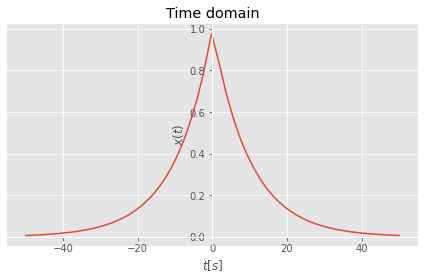

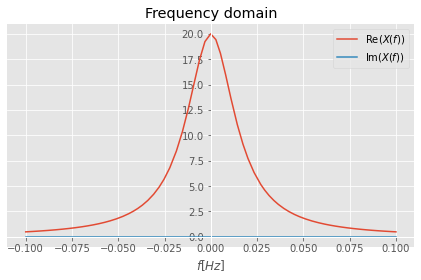

In [26]:
# Fourier transform of real signal

import sympy as sym
t, f = sym.symbols('t, f', real=True)
δ = sym.symbols('\delta', real=True, positive=True)
data = {δ: 0.1}
x = sym.exp(-δ*sym.Abs(t))
X = sym.fourier_transform(x, t, f)

sym.plot(x.subs(data), (t,-50,50), xlabel='$t [s]$', ylabel='$x(t)$', title='Time domain')
p1 = sym.plot(sym.re(X.subs(data)), (f,-.1,.1), xlabel='$f [Hz]$', label='Re$(X(f))$', ylabel='', 
              title='Frequency domain', show=False)
p2 = sym.plot(sym.im(X.subs(data)), (f,-.1,.1), line_color='C1', label='Im$(X(f))$', show=False)
p1.extend(p2)
p1.legend = True
p1.show()

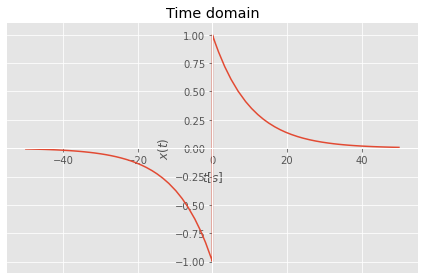

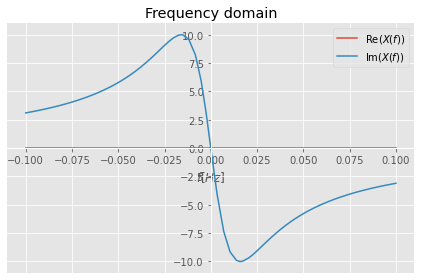

In [27]:
# Fourier transform of real signal

t, f = sym.symbols('t, f', real=True)
δ = sym.symbols('\delta', real=True, positive=True)
data = {δ: 0.1}
x = sym.sign(t)*sym.exp(-δ*sym.Abs(t))
X = sym.fourier_transform(x, t, f)

sym.plot(x.subs(data), (t,-50,50), xlabel='$t [s]$', ylabel='$x(t)$', title='Time domain')
p1 = sym.plot(sym.re(X.subs(data)), (f,-.1,.1), xlabel='$f [Hz]$', label='Re$(X(f))$', ylabel='', 
              title='Frequency domain', show=False)
p2 = sym.plot(sym.im(X.subs(data)), (f,-.1,.1), line_color='C1', label='Im$(X(f))$', show=False)
p1.extend(p2)
p1.legend = True
p1.show()

### Example:  Fourier transform of sine wave

Assume a sine function:

$$
x(t) = A\,\sin(2\pi\,p\,t),
$$

which we transform into:

$$
x(t) = \frac{A}{2\,\textrm{i}}\,
\left(e^{\textrm{i}\,2\pi\,p\,t)}-e^{-\textrm{i}\,2\pi\,p\,t)}
\right)
$$

and then we proceed with the calculation of the Fourier transform:

In [28]:
# Fourier transform of sine wave

import sympy as sym
A, t, f = sym.symbols('A, t, f', real=True)
p = sym.symbols('p', real=True, positive=True)
i = sym.I
π = sym.pi

x = A*(sym.exp(i*2*π*p*t)-sym.exp(-i*2*π*p*t))/(2*i)
X = sym.fourier_transform(x, t, f)
X

I*A*(FourierTransform(exp(-2*I*pi*p*t), t, f) - FourierTransform(exp(2*I*pi*p*t), t, f))/2

According to the properties of the Dirac delta function we know $\mathcal{F}_{t}\left[e^{-2 \textrm{i}\,\pi\,p\, t}\right]\left(f\right)=\delta(p+f)$ and therefore follows:

$$
\mathcal{F}_{t}\left( A\,\sin(2\pi\,p\,t)\right)=
\frac{\mathrm{i} A}{2} \delta(f - p) - \frac{\mathrm{i} A}{2}\delta(f + p)
$$

which we show in the picture below.

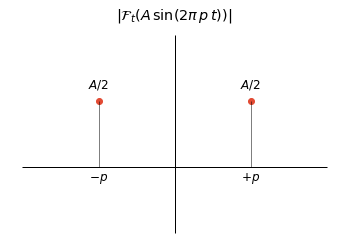

In [29]:
# Fourier transform of sine wave

import numpy as np
import matplotlib.pyplot as plt

A = 1
p = 10

fig, ax1 = plt.subplots()
plt.title('$|\\mathcal{F}_{t}\\left( A\,\sin(2\pi\,p\,t)\\right)|$')

ax1.set_xlabel('$f$')
ax1.set_ylabel('$|\\mathcal{F}()|$')
ax1.plot([-p, p], [A/2, A/2], 'o')
ax1.vlines(0, -0.5*A, A, 'k', lw=1)
ax1.vlines(-p, 0, A/2, 'k', lw=0.5)
ax1.vlines(p, 0, A/2, 'k', lw=0.5)
ax1.hlines(0, -2*p, 2*p, 'k', lw=1)
ax1.annotate('$-p$',
            xy=(-p, -0.5), xycoords='data',
            ha='center', size='large',
            xytext=(-p, -0.1), textcoords='data'
            )
ax1.annotate('$+p$',
            xy=(p, -0.5), xycoords='data',
            ha='center', size='large',
            xytext=(p, -0.1), textcoords='data'
            )
ax1.annotate('$A/2$',
            xy=(-p, A/2), xycoords='data',
            ha='center', size='large',
            xytext=(-p, A/2+.1), textcoords='data'
            )
ax1.annotate('$A/2$',
            xy=(p, A/2), xycoords='data',
            ha='center', size='large',
            xytext=(p, A/2+.1), textcoords='data'
            )
plt.axis('off')
plt.show()

### Example:  Fourier transform of rectangular pulse

Assume a rectangular function

$$
x(t) =
\begin{cases}
a&;\qquad |t|<b\\
0&;\qquad \textrm{sicer,}
\end{cases}
$$

with the Fourier transform being:

$$
X(f)=\int_{-\infty}^{+\infty} x(t)\,e^{-\textrm{i}\,2\pi\,f\,t}\,\textrm{d} t=
\int_{-b}^{+b} a\,e^{-\textrm{i}\,2\pi\,f\,t}\,\textrm{d} t=\frac{a \sin\left(2 \pi\,b\,f \right)}{\pi\,f},
$$


what we transform into

$$
X(f)=2\,a\,b\,\frac{\sin\left(2 \pi\,b\,f \right)}{2 \pi\,b\,f },
$$

because now we clearly see: when $f$ limits to 0, $X(f)$ limits to $2\,a\,b$; otherwise, it oscillates with frequency $1/b$ in the frequency domain. Some of the characteristics can be seen from the figure below: again we notice that the more the data is wide in time, the narrower it is in frequency

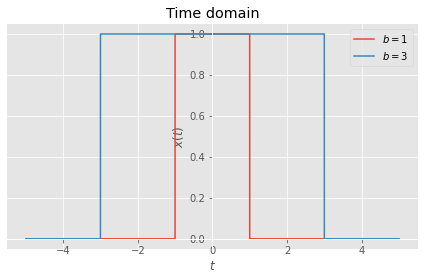

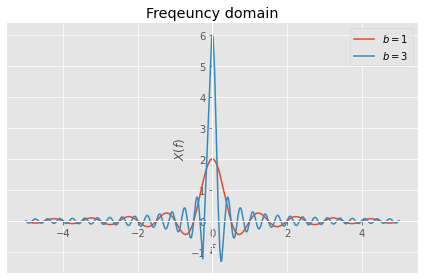

In [30]:
#  Fourier transform of rectangular pulse

a, b, f = sym.symbols('a, b, f', real=True, positive=True)
t = sym.symbols('t', real=True)
i = sym.I
π = sym.pi

x = a*sym.Heaviside(t+b) - a*sym.Heaviside(t-b)

X = sym.simplify(sym.integrate(a*sym.exp(-i*2*π*f*t), (t, -b, b)), trig=True)

data1 = {a: 1, b:1}
data2 = {a: 1, b:3}

p1 = sym.plot(x.subs(data1), (t, -5, +5), line_color='C0', label=f'$b={b.subs(data1)}$',show=False, 
              title='Time domain', ylabel='$x(t)$', xlabel='$t$')
p2 = sym.plot(x.subs(data2), (t, -5, +5), line_color='C1', label=f'$b={b.subs(data2)}$',show=False)
p1.extend(p2)
p1.legend = True
p1.show()
p1 = sym.plot(X.subs(data1), (f, -5, +5), line_color='C0', label=f'$b={b.subs(data1)}$',show=False, 
              title='Freqeuncy domain', ylabel='$X(f)$', xlabel='$f$')
p2 = sym.plot(X.subs(data2), (f, -5, +5), line_color='C1', label=f'$b={b.subs(data2)}$',show=False)
p1.extend(p2)
p1.legend = True
p1.show()

### Convolution of functions

Fourier transform of convolution of functions equald to the product of particular Fourier transforms:

$$
\mathcal{F}\big{\{}x(t)*y(t)\big{\}} = X(f)\,Y(f).
$$

Note: $*$ is used for convolution:

$$
\int_{-\infty}^{+\infty}\big(x(t)*y(t)\big)\,e^{-\textrm{i}2\pi\,f\,t}\textrm{d}t=\int_{-\infty}^{+\infty}\int_{-\infty}^{+\infty} x(\tau)\,y(t-\tau)\,\textrm{d}\tau\,\,e^{-\textrm{i}2\pi\,f\,t}\,\textrm{d}t
$$


In [31]:
# code
t, f, τ, v = sym.symbols('t, f, tau, v', real=True)
x = sym.Function('x')
y = sym.Function('y')
i = sym.I
π = sym.pi

X = sym.integrate(
        sym.integrate(x(τ)*y(t-τ)*sym.exp(-i*2*π*f*t), (τ, -sym.oo, +sym.oo)),
        (t, -sym.oo, +sym.oo))
X

Integral(exp(-2*I*pi*f*t)*Integral(x(tau)*y(t - tau), (tau, -oo, oo)), (t, -oo, oo))

In [32]:
X = X.transform(t-τ, v)
X

Integral(exp(-2*I*pi*f*(tau + v))*Integral(x(tau)*y(v), (tau, -oo, oo)), (v, -oo, oo))

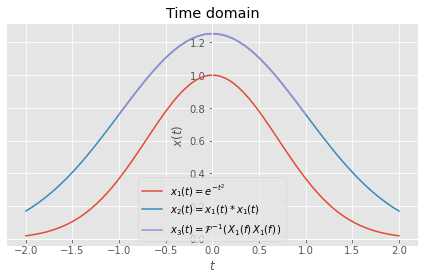

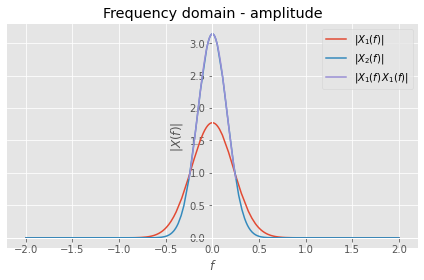

In [33]:
# code
t, f, τ = sym.symbols('t, f, τ', real=True)
i = sym.I
π = sym.pi

x_1 = sym.exp(-t**2)
x_2 = sym.integrate(x_1.subs(t,τ)*x_1.subs(t,t-τ), (τ, -sym.oo, +sym.oo)) # convolution in time domain

X_1 = sym.fourier_transform(x_1, t, f)
X_2 = sym.fourier_transform(x_2, t, f)

X_3 = X_1*X_1 # covolution in the freq domain
x_3 = sym.inverse_fourier_transform(X_2, f, t)

p1 = sym.plot(x_1, (t, -2, +2), line_color='C0', 
              label=f'$x_1(t)={sym.latex(x_1)}$', show=False,
              title='Time domain', ylabel='$x(t)$', xlabel='$t$')
p2 = sym.plot(x_2, (t, -2, +2), line_color='C1', 
              label=f'$x_2(t)=x_1(t)*x_1(t)$', show=False)
p3 = sym.plot(x_3, (t, -1., +1.), line_color='C2', 
              label='$x_3(t)=\\mathcal{F}^{-1}(\,X_1(f)\,X_1(f)\,)$', show=False)
p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()

p1 = sym.plot(sym.Abs(X_1), (f, -2, +2), line_color='C0',
              label=f'$|X_1(f)|$', show=False, 
              title='Frequency domain - amplitude', ylabel='$|X(f)|$', xlabel='$f$')
p2 = sym.plot(sym.Abs(X_2), (f, -2, +2), line_color='C1',
              label=f'$|X_2(f)|$', show=False)
p3 = sym.plot(sym.Abs(X_1*X_1), (f, -.25, +.25), line_color='C2',
              label=f'$|X_1(f)\,X_1(f)|$', show=False)
p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()

### Product of two functions

The Fourier transform of the product of two functions is equal to the convolution of particular Fourier transforms:

$$
\mathcal{F}\big{\{}x(t)\,y(t)\big{\}} = X(f)*Y(f).
$$

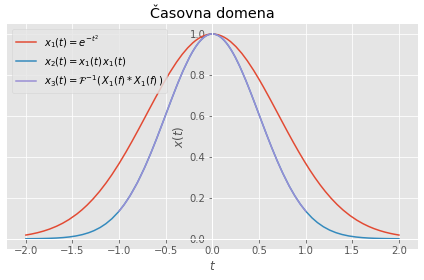

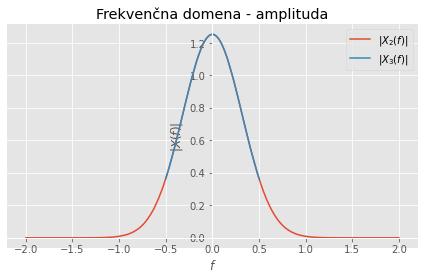

In [34]:
# code
t, f, f_1 = sym.symbols('t, f, f_1', real=True)
i = sym.I
π = sym.pi

x_1 = sym.exp(-t**2)
x_2 = x_1*x_1
X_1 = sym.fourier_transform(x_1, t, f)
X_2 = sym.fourier_transform(x_2, t, f) #produkt v času

X_3 = sym.integrate(X_1.subs(f, f_1)*X_1.subs(f, f-f_1), (f_1, -sym.oo, +sym.oo)) # konvolucija v frekvenci
x_3 = sym.inverse_fourier_transform(X_3, f, t)

p1 = sym.plot(x_1, (t, -2, +2), line_color='C0', 
              label=f'$x_1(t)={sym.latex(x_1)}$', show=False,
              title='Časovna domena', ylabel='$x(t)$', xlabel='$t$')
p2 = sym.plot(x_2, (t, -2, +2), line_color='C1', 
              label=f'$x_2(t)=x_1(t)\,x_1(t)$', show=False)
p3 = sym.plot(x_3, (t, -1., +1.), line_color='C2', 
              label='$x_3(t)=\\mathcal{F}^{-1}(\,X_1(f)*X_1(f)\,)$', show=False)
p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()

p1 = sym.plot(sym.Abs(X_2), (f, -2, +2), line_color='C0',
              label=f'$|X_2(f)|$', show=False, 
              title='Frekvenčna domena - amplituda', ylabel='$|X(f)|$', xlabel='$f$')
p2 = sym.plot(sym.Abs(X_3), (f, -.5, +.5), line_color='C1',
              label=f'$|X_3(f)|$', show=False)
p1.extend(p2)
p1.legend = True
p1.show()

## PSD

The PSD definition is based on the auto-correlation function, which implicitly contains the frequency content, while satisfying the Dirichlet condition (at least in the case of processes with zero mean):

$$
\int_{-\infty}^{+\infty} \left|x(t)\right| \textrm{d} t < \infty
$$

Since the auto-correlation function and the PSD are a pair of Fourier transforms, we can write the following (Wiener-Khinchin) relations for the random processes $x(t)$ and $y(t)$:

$$
\begin{split}
S_{xx}(f) &= \mathcal{F}\{R_{xx}(\tau)\} \\
S_{xy}(f) &= \mathcal{F}\{R_{xy}(\tau)\}
\end{split}
$$

### Example: Fourier transform pair: auto-correlation function and PSD

According to the Wiener-Khinchin theorem, PSD of the sine wave is obtained as Fourier integral of auto-correlation function. As in previous example, considering sinusoidal signal $x(t) = A \mathrm{sin}(\omega\,t + \phi)$, the theoretical autocorrelation functions is

$$
R_{xx}(\tau) = \frac{A^2}{2} \mathrm{cos}(\omega\,\tau)
$$
 
Assuming the random variable $\phi$, the autocorrelation function is obtained via ensemble average at time $t$.

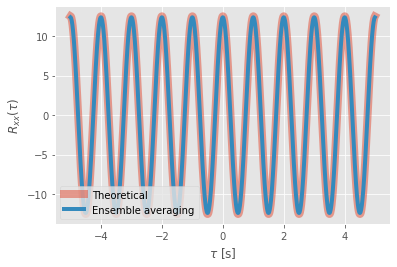

In [35]:
# Fourier transform pair: auto-correlation function and PSD

A = 5 #amlitude
f0 = 1 #frequency
omega = 2 * np.pi * f0
fs = 100 # sampling frequency
t0 = 0 # observation time t

seed = 123
rg =  np.random.default_rng(seed)
N = 1000 #size of ensemble
theta = rg.random(N) * 2*np.pi #random phase from 0-2pi
x0 = A*np.sin(omega*t0+theta) #  values at t0


# theoretical value
max_lag_s = 5 # observation time is t0+-5 seconds
tau = np.arange(-max_lag_s, +max_lag_s, 1/fs) #observation time
Rxx = A**2/2*np.cos(omega*tau)


# Ensemble averaging
Rxx1 = [] 
for tau_i in tau:
    tmp = A*np.sin(omega*(t0+tau_i)+theta) # value of sine at t0+tau_i
    tmp = x0 * tmp 
    Rxx1.append(tmp)
    
Rxx1 = np.array(Rxx1)
Rxx1 = Rxx1.mean(axis=1) #averaging over phase


plt.plot(tau, Rxx, lw=8, alpha=.5, label='Theoretical')
plt.plot(tau, Rxx1, lw=4, label='Ensemble averaging')

plt.legend(loc='lower left')
plt.xlabel('$\\tau$ [s]')
plt.ylabel('$R_{xx}(\\tau)$');

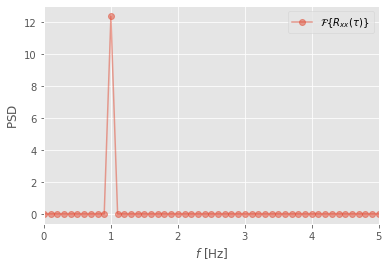

In [36]:
#  Fourier transform pair: auto-correlation function and PSD

# Wiener-Khinchin theorem
X = np.fft.rfft(Rxx1)
f = np.fft.rfftfreq(len(Rxx1), d=1/fs)

# plot
fig, ax= plt.subplots()
ax.plot(f,2 * np.abs(X)/len(Rxx), 'o-', label='$\mathcal{F}\{R_{xx}(\\tau)\}$', alpha=.5) #one sided, normalized to samšle size
plt.legend()
ax.set_xlim(0,5)
ax.set_xlabel('$f$ [Hz]');
ax.set_ylabel('$\mathrm{PSD}$');

### Example: Fourier transform pair: autocorrelation function and PSD

According to the Wiener-Khinchin theorem, PSD is obtained as Fourier integral of auto-correlation function. In this example ensemble of random processes is first synthesized. Autocorrelation function is obtained via ensemble averaging, followed by its Fourier transformation as resulting PSD. 

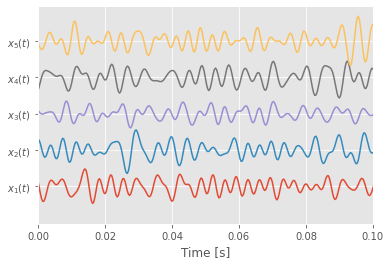

In [37]:
#  Fourier transform pair: auto-correlation function and PSD

import numpy as np
import FLife

#  Define PSD 
rms = 3  # RMS of random process
freq = np.arange(0,1000)
f_low, f_high = 100, 300 
PSD = np.interp(freq, [f_low, f_high], [1,1], left=0, right=0) 
PSD = PSD/np.trapz(PSD, freq) * rms**2

# random processes
N = 1000 
seed = 123
rg =  np.random.default_rng(seed)
T, fs = 1, 10*f_high
data = [FLife.tools.random_gaussian(freq=freq, PSD=PSD, T=T, fs=fs, rg=rg)[1] for i in range(N)] # N zero-mean processes
time = np.arange(0, T, 1/fs)

#plot firt 5 random processes
fig, ax= plt.subplots()
y_ticks = []
for n in range(5):
    signal_offset = 5*n*rms
    ax.plot(time, data[n] + signal_offset)
    y_ticks.append(signal_offset)
    
ax.set_yticks(y_ticks, labels=[f'$x_{i+1:g}(t)$' for i in range(5)])
ax.set_xlim(0,.1)
ax.set_xlabel('Time [s]');
plt.show()

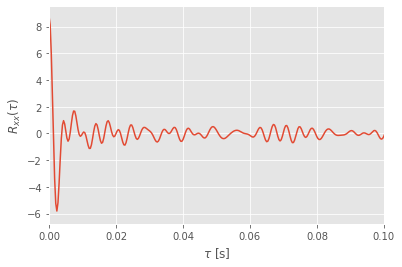

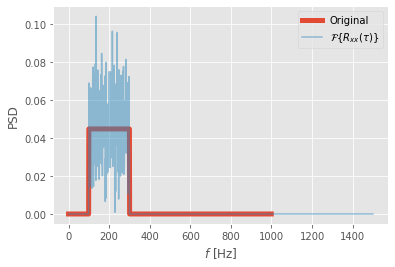

In [38]:
#  Fourier transform pair: auto-correlation function and PSD

t_1 = 0 # observation time t1
sel_t1 = np.argmin(np.abs(t_1 - time))
Rxx_N = np.zeros_like(data)

for n in range(N): # ensemble of observations
    sig = data[n] # n-th observation        
    
    for lag in range(len(sig)):    
        Rxx_N[n, lag] = sig[sel_t1] * sig[sel_t1 + lag]
        
Rxx = Rxx_N.mean(axis=0)

fig, ax= plt.subplots()
ax.plot(time, Rxx, label='rxx')
ax.set_xlim(0,0.1)
ax.set_xlabel('$\\tau$ [s]');
ax.set_ylabel('$R_{xx}(\\tau)$');

X = np.fft.rfft(Rxx)
f = np.fft.rfftfreq(len(Rxx), d=1/fs)

fig, ax= plt.subplots()
ax.plot(freq, PSD, lw=5, label='Original')
ax.plot(f,2 * np.abs(X)/len(Rxx), label='$\mathcal{F}\{R_{xx}(\\tau)\}$', alpha=.5) #one sided, normalized to samšle size
plt.legend()
#ax.set_xlim(0,0.1)
ax.set_xlabel('$f$ [Hz]');
ax.set_ylabel('PSD');

Alternatively to Fourier transform of autocorrelation function, $\mathcal{F}\{R_{xx}(\tau)\}$, the PSD can be obtained by multiplication of Fourier transform of signals. In the case of measured data, the time history $x_\mathrm{T}(t)$ is of finite length $T$ and the Dirichlet condition is satisfied

![windowing_time](./figures/windowing_time.svg)

Considering Parseval theorem it can be shown that

$$
\frac{1}{T}\int_{-T/2}^{T/2} x_\mathrm{T}^2(t)\,\mathrm{d}t = \int_{-\infty}^{\infty}\frac{1}{T}\left|X_\mathrm{T}(f)\right|^2\mathrm{d}f = \int_{-\infty}^{\infty} \hat{S}_{xx}(f)\,\mathrm{d}f
$$

where the quantity $\frac{1}{T}\left|X_\mathrm{T}(f)\right|^2$ is called the ***raw*** (or sample) PSD. 

However $\hat{S}_{xx}(f)$ does not converge (in a statistical sense) as $\lim_{T\to\infty}$. In fact,  $\hat{S}_{xx}(f)$ is not ergodic. So some method of reducing the variability is required:
 
 $\mathrm{Var}(X(t)) = \sigma_x^2 = \int_{-\infty}^{\infty}\lim_{T\to\infty}\frac{E\left[\left|X(f)\right|^2\right]}{T}\,\mathrm{d}f = \int_{-\infty}^{\infty} S_{xx}(f)\,\mathrm{d}f$

By averaging the sample PSD over the ensemble, the **Auto (PSD)** and **Cross (CSD)** spectral density is obtained for the case of an ergodic process as:
$$
\begin{split}
S_{xx}(f) &= \lim_{T\to\infty}\frac{E\left[X^*(f) \, X(f)\right]}{T}, \qquad\text{PSD}\\
S_{xy}(f) &= \lim_{T\to\infty}\frac{E\left[X^*(f) \, Y(f)\right]}{T}, \qquad\text{CSD}
\end{split}
$$


The auto-spectral density $S_{xx}$ covers negative and positive frequencies and is therefore also called a *bilateral* spectral density function. A one-sided spectral density function $G_{xx}$ is often used, which is defined as:

$$
G_{xx} = 
\begin{cases}
2\,S_{xx}(f), & f>0\\
S_{xx}(f),& f=0\\
0,&f<0
\end{cases}
$$


## Spectral moments

Due to the definition of PSD, it follows that the area under the curve is equal to the expected squared value $E[x^2]$ of the process:

$$
m_0 = E \left[x^2(t)\right] = \int_{-\infty}^{+\infty} S_{xx}(\omega)\, \textrm{d} \omega
$$

where $m_0$ is the zero spectral moment equal to the variance $\sigma_x^2$ of the zero mean process. The higher even moments correspond to the variance of the time derivatives of the original random process:

$$
m_2 = E \left[\dot{x}^2(t)\right] = \int_{-\infty}^{+\infty} \omega^2 \, S_{xx}(\omega) \,\textrm{d} \omega
$$

The general expression for the $i$th spectral moment $m_i$ can be written in the form:

$$
m_i = \int_{-\infty}^{+\infty} \omega^i \, S_{xx}(\omega) \textrm{d} \omega=\int_{0}^{+\infty} \omega ^i \, G_{xx}(\omega) \,\textrm{d} \omega
$$

where $G_{xx}$ is a one-sided PSD.

It should be emphasized that if the PSD is given in Hz ($G_{xx}(f)$) the correct use of the handle $(2\pi\,f)^i$ should not be forgotten:
$$
m_i = \int_{0}^{+\infty} (2\pi\,f)^i \, G_{xx}(f) \,\textrm{d} f
$$

### Example: Spectral moments

In this example a harmonic response with amplitude $A=1$ is defined. The displacement variance is expected: $(A/\sqrt{2})^2=0.5\,A$, and the velocity variance: $((2\pi\,f_0\,A)/\sqrt{2})^ 2=2\pi^2\,f_0^2\,A$ and the acceleration variance $(((2\pi\,f_0)^2\,A)/\sqrt{2})^2=2^3( \pi\,f_0)^4\,A$.

0.5000000000000002 0.4999994999999835


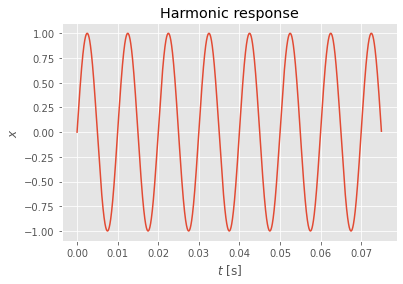

In [39]:
# Spectral moments

N = 1_000_000
T = 15
f_0 = 100
time,  dt = np.linspace(0, T, N, retstep=True)
x = np.sin(2*np.pi*f_0*time)
X = np.fft.rfft(x)
freq = np.fft.rfftfreq(N, dt)
PSD = 2 * np.abs(X)**2 * dt/N # Eqvivalent PSD

plt.title('Harmonic response')
plt.plot(time[:5000], x[:5000])
plt.xlabel('$t$ [s]')
plt.ylabel('$x$')

print(np.trapz(x**2, dx=dt)/T, np.trapz(PSD,freq))

In [40]:
def spectral_moment(PSD, freq, i=0):
    return np.trapz((2*np.pi*freq)**i * PSD, freq)

Spectral moment $m_0$ (displacement): let's check if we really get the expected value ($0.5\,A=0.5$) also in the frequency domain:

In [41]:
np.trapz(x**2, dx=dt)/T, spectral_moment(PSD=PSD, freq=freq, i=0)

(0.5000000000000002, 0.4999994999999835)

Spectral moment $m_2$ (velocity): we expect the value $2\pi^2\,f_0^2\,A=197392.08$ for the velocity:

In [42]:
v = np.gradient(x)/dt
np.trapz(v**2, dx=dt)/T, spectral_moment(PSD=PSD, freq=freq, i=2)

(197386.24353385586, 197392.04313259336)

# Zero and peak crossing rates
<a id='Zero_and_peak_crossing_rates'></a>

Fatigue analysis is based largely on the local extreme values of a signal and the implied damaging cycles, as observed in the time domain. Those phenomena are not present in the frequency domain and therefore special estimators are devised to describe them in a probabilistic way. Here the zero and peak crossing rates of cycles are discussed, both being dependent on the spectral width of the random process.


![narrowband_broadband_RP](./figures/narrowband_broadband_RP.svg)

Based on spectral moments, the frequency of the positive slope zero crossing $\nu_0^+$ and the expected peak frequency $\nu_\mathrm{p}$ are defined as:

$$
\begin{split}
    \nu_0^+ &= \frac{1}{2\pi} \, \sqrt{\frac{m_2}{m_0}}, \\ \nu_\mathrm{p} &= \frac{1}{2\pi} \, \sqrt{\frac{m_4}{m_2}}
\end{split}
$$

## Irregularity factor

To describe the spectral width of the random process the bandwidth parameter $\alpha_i$ is defined as:

$$
\begin{equation}
    \alpha_i = \frac{m_i}{\sqrt{m_0 \, m_{2i}}}
\end{equation}
$$

where the most commonly used $\alpha_2$, known as the irregularity factor, represents the ratio of the positive slope zero crossing and expected peak frequency

$$
\begin{equation}
    \alpha_2 = \frac{m_2}{\sqrt{m_0 \, m_{4}}} = \frac{\nu_0^+}{\nu_\mathrm{p}}
\end{equation}
$$

In general, for a narrowband process the irregularity factor approaches one, whereas it tends towards zero with an increase of the frequency width of a random process. Alternatively, the spectral width parameter $\epsilon$ is used by some researchers (close to zero for narrowband and close to one for broadband process):

$$
\begin{equation}
    \epsilon= \sqrt{1 - \alpha_2^2}
\end{equation}
$$

### Example: Zero and peak crossing frequency

Define bimodal random process using the PSD, then generate time series. Calculate zero and peak crossing frequency in both time and frequency domain.

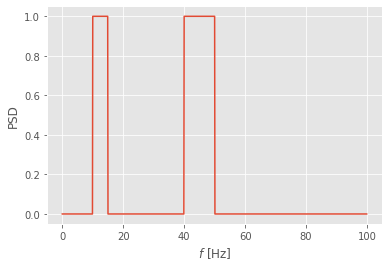

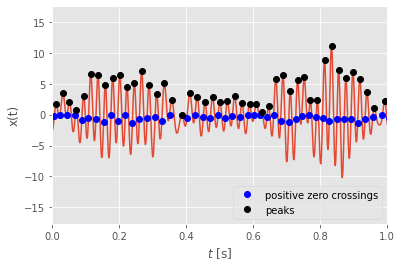

In [43]:
# Zero and peak crossing frequency

#Define PSD
freq= np.arange(0,100,.1)
PSD = np.interp(freq, [10,15,15,40,40,50],[1,1,0,0,1,1], left=0, right=0)
plt.plot(freq, PSD)
plt.xlabel('$f$ [Hz]')
plt.ylabel('PSD')
plt.show()

# Time series
T = 100
fs = 1e3
seed = 1
rg = np.random.default_rng(seed)
time, time_series = FLife.tools.random_gaussian(freq, PSD, T=T, fs=fs, rg=rg)
indx_peaks = signal.argrelextrema(time_series, np.greater)
sign_diff = np.diff(np.sign(time_series))
indx_zeros_up = np.where(sign_diff>0)

plt.plot(time, time_series)
plt.plot(time[indx_zeros_up], time_series[indx_zeros_up], 'ob', label='positive zero crossings')
plt.plot(time[indx_peaks], time_series[indx_peaks], 'ok', label='peaks')
plt.xlabel('$t$ [s]')
plt.ylabel('x(t)')
plt.xlim(0, 1)
plt.legend(loc = 'lower right');
plt.show()

In [44]:
# Zero and peak crossing frequency - time domain

zero_rate_t = len(time_series[indx_zeros_up])/T
peak_rate_t = len(time_series[indx_peaks])/T
zero_rate_t, peak_rate_t

(37.5, 44.78)

In [45]:
# Zero and peak crossing frequency - frequency domain

m0 = spectral_moment(PSD, freq, 0)
m2 = spectral_moment(PSD, freq, 2)
m4 = spectral_moment(PSD, freq, 4)

zero_rate_f = 1/(2*np.pi)*np.sqrt(m2/m0)
peak_rate_f = 1/(2*np.pi)*np.sqrt(m4/m2)
zero_rate_f, peak_rate_f

(37.5788574839806, 44.69146631982286)

In [46]:
# Zero and peak crossing frequency - irregulariyt factor

α2 = zero_rate_f/peak_rate_f
α2

0.8408508509221263

Source of this tutorial: https://github.com/ladisk/WCFA-22-VFA-Talk
<img src="./figures/WCFA-VFA_logoFin_Linear.png">

Nov 15th 2022

<span style="font-family: 'Lucida Console'; font-size: 50px; text-align: center">Signal Processing, Part 2</span>

prof. dr. Janko Slavič, Aleš Zorman

Contact: janko.slavic@fs.uni-lj.si, www.ladisk.si, Twitter: jankoslavic

ToC:

- [System Transfer Functions (Frequency Domain)](#System_Transfer_Functions)
- [Estimating frequency response function](#Estimating_frequency_response_function)
- [How transfer functions work](#How_transfer_functions_work)
- [FFT and PSD](#FFT_and_PSD)
- [Calculating PSD From Time Signals](#Calculating_PSD_From_Time_Signals)

# System Transfer Functions (Frequency Domain)
<a id='System_Transfer_Functions'></a>

![transfer_function](./figures/transfer_function.svg)

The box marked ‘System’ is a convenient catch-all term for phenomena of great variety
and complexity. From the outset, we shall impose major constraints on what the box represents:

- Linear: $P\{\alpha_1\,f_1(t)+\alpha_2\,f_2(t)\}=\alpha_1\,P\{f_1(t)\} +\alpha_2\,P\{f_2(t)\}$

- Time invariant: $P\{f(t-t_0)\}=y(t-t_0)$

Such systems are very usefully described by a particular feature, namely their response to an ideal impulse $\delta(t)$ and
their corresponding behaviour is then the impulse transfer function $h(t)$:

- $h(t)=P\{\delta(t)\}$

Because the system is linear this rather ‘abstract’ notion turns out to be very useful
in predicting the response of the system to any arbitrary input. This is expressed by the
convolution of input $f(t)$ and system $h(t)$:

$x(t)=h(t)*f(t)=\int_{-\infty}^{t}h(t-\tau)f(\tau)\mathrm{d}\tau = \int_{0}^{\infty}h(\tau)f(t-\tau)\mathrm{d}\tau$

### Example: Response of 1 DOF mechanical system

![structural_SDOF_model](./figures/structural_SDOF_model.svg)

*Equation of motion (EOM)*:

$$
\ddot{x}(t)+2\,\delta\,\omega_0\,\dot{x}(t)+\omega_0^2\,x(t) = 0
$$

$$
\omega_0 = \sqrt{\frac{k}{m}}, \quad  \delta = \frac{c}{2\,\sqrt{k\,m}}
$$

*Impulse transfer function*:

$$
	h(t)=x(t)=\frac{1}{m\,\omega_{d}}\,e^{-\zeta\,\omega_0\,(t)}\,\sin(\omega_{d}\,(t))
$$

$$
\omega_{d} = \omega_0\,\sqrt{1-\delta^2}
$$

### Example:  Response of linear oscillator to step function

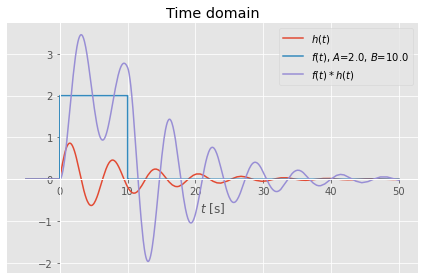

In [47]:
# Response of linear oscillator to step function

import sympy as sym
t, ω_0, ω_d, d_x_0, δ, A, B, τ = sym.symbols('t, \omega_0, \omega_d, d_x_0, \delta, A, B, \\tau', real=True)
π = sym.pi
data = {ω_0: 1, d_x_0: 1, δ: 0.1, A: 2., B: 10.}

ω_d = ω_0 * sym.sqrt(1-δ**2)
envelope = d_x_0/ω_d * sym.exp(-δ*ω_0*t)
h = envelope * sym.sin(ω_d*t)*sym.Heaviside(t)

f = A*(sym.Heaviside(t)-sym.Heaviside(t-B))

fh = (f.subs(t, τ)*h.subs(t, t-τ)).subs(data)
fh = sym.integrate(fh, (τ, 0, t))

p1 = sym.plot(h.subs(data), (t,-5,50), line_color='C0', xlabel='$t$ [s]', ylabel='', title='Time domain',
             label='$h(t)$', show=False)
p2 = sym.plot(f.subs(data), (t,-5,50), line_color='C1', 
             label=f'$f(t)$, $A$={A.subs(data):3.1f}, $B$={B.subs(data):3.1f}', show=False)
p3 = sym.plot(fh, (t,-5,50), line_color='C2', 
             label='$f(t)*h(t)$', show=False)
p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()

Taking the Fourier transform of the convolution results in multiplication:

$$
X(f) = H(f)\,F(f)
$$

Following on from this the relationship between the input and output the frequency transfer function is

$$
H(f) = \frac{X(f)}{F(f)}
$$

The impulse transfer function and the frequency transfer function are the **Fourier pair**:

$$
h(t)=\mathcal{F}^{-1}\{\alpha(\omega)\}\qquad\textrm{or}\qquad%
\alpha(\omega)=\mathcal{F}\{h(t)\}.
$$

Dependent on the measured response (displacement, velocity, acceleration), different forms of frequency transfer function exist:

$$
	\begin{aligned}
		\alpha(\omega)&=\frac{X(\omega)}{F(\omega)},&&\textrm{receptance}\\
		Y(\omega)&=\frac{\dot X(\omega)}{F(\omega)}= \mathrm{i}\,\omega\,\alpha(\omega),&&\textrm{mobility}\\
		A(\omega)&=\frac{\ddot X(\omega)}{F(\omega)}=-\omega^2\,\alpha(\omega),&&\textrm{accelerance}\\
	\end{aligned}
$$

### Example: different forms of FRF;  1 DOF mechanical system 

$$
	\alpha(\omega) = \frac{X(\omega)}{F(\omega)}=\frac{1}{-\omega^2\,m+ \mathrm{i}\,\omega\,c+k}.
$$

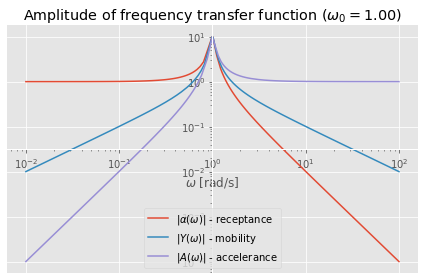

In [48]:
# different forms of FRF 

ω, m, c, k= sym.symbols('\omega, m, c, k', real=True)
i = sym.I

α = 1/(-ω**2 * m + i*ω*c + k)
data = {m: 1, c: 0.1, k: 1}

p1 = sym.plot(sym.Abs(α.subs(data)), (ω,0.01,100), line_color='C0', xlabel='$\omega$ [rad/s]', ylabel='',  
             title=f'Amplitude of frequency transfer function ($\\omega_0=${sym.sqrt(k/m).evalf(subs=data):3.2f})',
             label='$|\\alpha(\\omega)|$ - receptance', xscale='log', yscale='log', show=False)
p2 = sym.plot(sym.Abs(i*ω*α.subs(data)), (ω,0.01,100), line_color='C1', 
             label='$|Y(\\omega)|$ - mobility', xscale='log', yscale='log', show=False)
p3 = sym.plot(sym.Abs(-ω**2*α.subs(data)), (ω,0.01,100), line_color='C2', 
             label='$|A(\\omega)|$ - accelerance', xscale='log', yscale='log', show=False)
p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()

# Estimating frequency response function
<a id='Estimating_frequency_response_function'></a>

The objective of this section is to show how we can estimate the frequency transfer function of a linear time-invariant system when the input is a stationary random process

![transfer_function](./figures/transfer_function_SISO.svg)

Given the Fourier transform of input $f(t)$ and output $x(t)$, the **Auto (PSD)** and **Cross (CSD)** spectral density is defined as :

$$
\begin{split}
S_{ff}(f) &= \lim_{T\to\infty}\frac{E\left[F^*(f) \, F(f)\right]}{T}\\
S_{xx}(f) &= \lim_{T\to\infty}\frac{E\left[X^*(f) \, X(f)\right]}{T}\\
S_{fx}(f) &= \lim_{T\to\infty}\frac{E\left[F^*(f) \, X(f)\right]}{T}
\end{split}
$$

## Coherence

A measure of the linear relationship between the input (the excitation $f$) and the output (the response $x$) of the system is given by coherence

$$
\gamma_{fx}^2(f)=\frac{|G_{fx}(f)|^2}{G_{ff}(f)\,G_{xx}(f)}
=\frac{|S_{fx}(f)|^2}{S_{ff}(f)\,S_{xx}(f)}
$$



The coherence $\gamma_{fx}^2(f)$ assumes a value in the range from 0 to 1:

$$
0\le\gamma_{fx}^2(f)\le 1
$$

If the coherence is 1, the excitation and the response are linearly dependent. If the coherence is 0, the excitation and response are not linearly dependent. Deviation from 1 is also measured when there is

- noise in the measurement 
- we are dealing with a nonlinear system
- the response is due to (also) other excitations and not only $f(t)$.

Although assumed that both input and output are measurable, in reality they may be noise contaminated and it is not possible to measure the actual actual input $u(t)$ and output of the system $v(t)$.

![FRF_noise](./figures/FRF_noise.svg)

Instead, we measure the input and output with noise:

$$
\begin{split}
f(t)&=u(t)+m(t)\\
x(t)&=v(t)+n(t)
\end{split}
$$

The input $u(t)$ and the output $v(t)$ of the system are related using the FRF:

$$
\begin{split}
S_{vv}(\omega)&=|\alpha(\omega)|^2\,S_{uu}(\omega),\\
S_{uv}(\omega)&=\alpha(\omega)\,S_{uu}(\omega).
\end{split}
$$

## H1 estimator

Accurate when the response $x(t)$ covers a higher dynamic range than the excitation $f(t)$, i.e. at resonance, where the input noise ($m(t)=0$) can be neglected:

$$
\begin{split}
\hat{H}_1(\omega)&=\hat{\alpha}_1(\omega)=\frac{\hat{S}_{fx}(\omega)}{\hat{S}_{ff }(\omega)},
\end{split}
$$

To assess the quality and linearity of the measurement, we also need coherence:

$$
\begin{split}
\hat{\gamma}_{fx}^2&=\frac{|\hat{S}_{fx}|^2}{\hat{S}_{ff}\,\big(\underbrace{{S}_{vv}+S_{nn}}_{\hat{S}_{xx}}\big)},
\end{split}
$$

indicating that the noise at the output $S_{nn}(\omega)$ reduces the coherence and thus the quality of the estimated FRF.

## H2

Accurate when the noise on the response side can be neglected ($n(t)=0$), i.e. at antiresonance.

$$
\begin{split}
\hat{H}_2(\omega)&=\hat{\alpha}_2(\omega)=\frac{\hat{S}_{xx}}{\hat{S}_{xf}}.
\end{split}
$$


The coherence function:

$$
\begin{split}
\hat{\gamma}_{fx}^2&=\frac{|\hat{S}_{fx}|^2}{\big(\underbrace{{S}_{uu}+{S}_{mm}}_{\hat{S}_{ff}}\big)\,\hat{S}_{xx}}
\end{split}
$$

indicating that excitation-side noise also reduces the coherence and thus the quality of the estimated FRF.

By dividing the estimate $\hat{H}_1$ by the estimate $\hat{H}_2$, we get the coherence estimate:

$$
\begin{split}
\hat{\gamma}_{fx}^2&=\frac{\hat{H}_1}{\hat{H}_2}.
\end{split}
$$

### Example: Estimating the frequency transfer function  with the $H_1$ and $H_2$ estimators

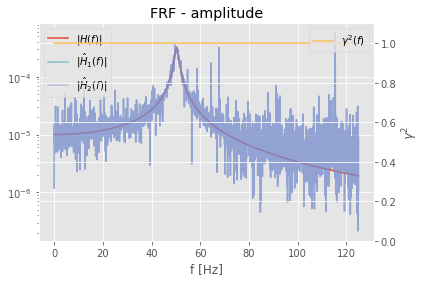

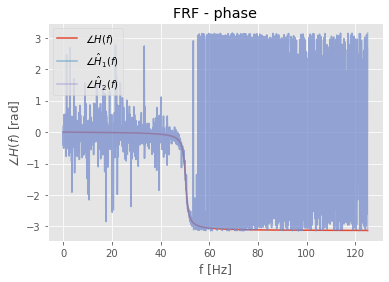

In [49]:
#  Estimating the frequency transfer function

rng = np.random.default_rng(0)
fs = 250
N = 5000
dt = 1./fs
time = np.arange(N)*dt

SNR_f = 20 # 20dB means that the signal-to-noise ratio is 10
SNR_x = 20

σ_u = 1
σ_m = σ_u/10**(SNR_f/20) # based on the definition 20*np.log10(σ_u/σ_m)

u = rng.normal(size=N, scale=σ_u)
m = rng.normal(size=N, scale=σ_m)

f = u + m # measured excitation (time domain)

scale = 1.0 / (fs*N)
U = np.fft.rfft(u) # actual excitation 
F = np.fft.rfft(f) # measured excitation 
freq = np.fft.rfftfreq(N, d=dt)

G_uu = 2*scale*np.abs(U.conj()*U)
G_ff = 2*scale*np.abs(F.conj()*F)

def alpha(freq, m, k, c):
    """
    frequency transfer function of linear oscilator.
    """
    omega = 2*np.pi*freq
    return 1 / (-omega**2*m + 1j*omega*c + k)

H = alpha(freq, m=1,k=1e5,c=10)
V = H*U                      # response without the noise
v = np.fft.irfft(V)        # actual response (time domain)
σ_n = np.std(v)/10**(SNR_x/20) # based on the definition 20*np.log10(σ_v/σ_n)
n = rng.normal(size=N, scale=σ_n)

x = v + n            # measured response (time domain)
X = np.fft.rfft(x) # measured response (freqeuncy domain)

G_fx = 2*scale*F.conj()*X
G_xx = 2*scale*np.abs(X.conj()*X)
G_xf = G_fx.conj()

H1 = G_fx/G_ff
H2 = G_xx/G_xf
γ2 = np.abs(H1/H2)

fig, ax = plt.subplots()
ax.set_title('FRF - amplitude')
ax.semilogy(freq, np.abs(H), label='$|H(f)|$')
ax.semilogy(freq, np.abs(H1), label='$|\\hat H_1(f)|$', alpha=0.5)
ax.semilogy(freq, np.abs(H2), label='$|\\hat H_2(f)|$', alpha=0.5)
ax.set_xlabel('f [Hz]')
ax.legend(loc=2)
ax2 = ax.twinx() 
ax2.plot(freq, γ2, 'C4', label='$\\gamma^2(f)$')
ax2.set_ylabel('$\\gamma^2$')
ax2.set_ylim(0,1.1)
ax2.legend(loc=1)
plt.show()

fig, ax = plt.subplots()
ax.set_title('FRF - phase')
ax.plot(freq, np.angle(H), label='$\\angle H(f)$')
ax.plot(freq, np.angle(H1), label='$\\angle\\hat H_1(f)$', alpha=0.5)
ax.plot(freq, np.angle(H2), label='$\\angle\\hat H_2(f)$', alpha=0.5)
ax.set_xlabel('f [Hz]')
ax.set_ylabel('$\\angle H(f)$ [rad]')
ax.legend()
plt.show()

### Example: Estimating the frequency transfer function  with the $H_1$ and $H_2$ estimators -  segment averaging

We continue with the example and add averaging by sections; thereby reducing the frequency accuracy and also the scatter of the frequency transfer function estimator.

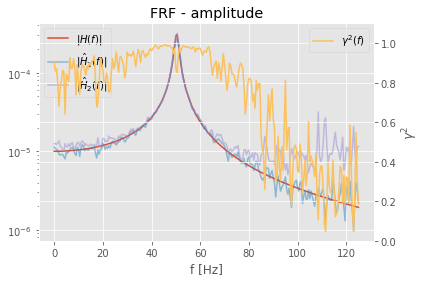

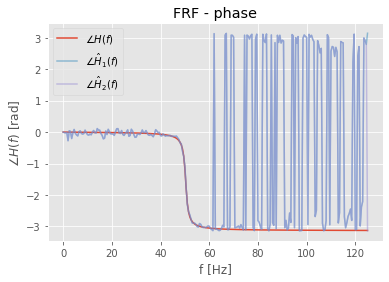

In [50]:
# Estimating the frequency transfer function - segment averaging

segments = 10
N_ = N//segments
win = signal.windows.hann(N_)              # window
scale = 1.0 / (fs*(win*win).sum())

G_fx = np.zeros(N_//2+1, dtype=complex) 
G_ff = np.zeros(N_//2+1, dtype=complex)
G_xf = np.zeros(N_//2+1, dtype=complex)
G_xx = np.zeros(N_//2+1, dtype=complex)

for i in range(segments):
    f_ = f[i*N_:(i+1)*N_]
    x_ = x[i*N_:(i+1)*N_]
    f_w = win*f_          # window
    x_w = win*x_
    F = np.fft.rfft(f_w)  # fft
    X = np.fft.rfft(x_w)
    G_fx += scale*2*np.conj(F) * X / segments # averaging the PSD and CSD estimators
    G_ff += scale*2*np.conj(F) * F / segments 
    G_xf += scale*2*np.conj(X) * F / segments 
    G_xx += scale*2*np.conj(X) * X / segments

freq = np.fft.rfftfreq(N_, d=dt)
H = alpha(freq, m=1, k=1e5, c=10)

H1 = G_fx/G_ff
H2 = G_xx/G_xf
γ2 = np.abs(H1/H2)

sel = freq>=0
#sel = np.logical_and(freq>40, freq<60)    # closer look to resonance area
fig, ax = plt.subplots()
ax.set_title('FRF - amplitude')
ax.semilogy(freq[sel], np.abs(H[sel]), label='$|H(f)|$')
ax.semilogy(freq[sel], np.abs(H1[sel]), label='$|\\hat H_1(f)|$', alpha=0.5)
ax.semilogy(freq[sel], np.abs(H2[sel]), label='$|\\hat H_2(f)|$', alpha=0.5)
ax.set_xlabel('f [Hz]')
ax.legend(loc=2)
ax2 = ax.twinx() 
ax2.plot(freq[sel], γ2[sel], 'C4', label='$\\gamma^2(f)$')
ax2.set_ylabel('$\\gamma^2$')
ax2.set_ylim(0,1.1)
ax2.legend(loc=1)
plt.show()

fig, ax = plt.subplots()
ax.set_title('FRF - phase')
ax.plot(freq[sel], np.angle(H[sel]), label='$\\angle H(f)$')
ax.plot(freq[sel], np.angle(H1[sel]), label='$\\angle\\hat H_1(f)$', alpha=0.5)
ax.plot(freq[sel], np.angle(H2[sel]), label='$\\angle\\hat H_2(f)$', alpha=0.5)
ax.set_xlabel('f [Hz]')
ax.set_ylabel('$\\angle H(f)$ [rad]')
ax.legend()
plt.show()

# How transfer functions work
<a id='How_transfer_functions_work'></a>

## Single input

How to obtain spectral density of the response, when excitation and the transfer function are known?

![transfer_function_response](./figures/transfer_function_SISO_response.svg)

The Auto-spectral density (PSD) of the response can be obtained as:

$$
S_{xx}(f) = H^*(f)\,H(f)\,S_{ff}(f),
$$

and the Cross-spectral density (CSD) as:

$$
\begin{split}
S_{fx}(f) &= H(f)\,S_{ff}(f)\\
S_{xf}(f) &= S_{fx}^*(f) = H^*(f)\,S_{ff}(f)
\end{split}
$$

where ${}^*$ denotes the complex conjugate.

### Example: Calculating the response PSD and CSD for a system subjected to single excitation

Using the example below, we will look at auto- and cross-spectral density of normally distributed random data.

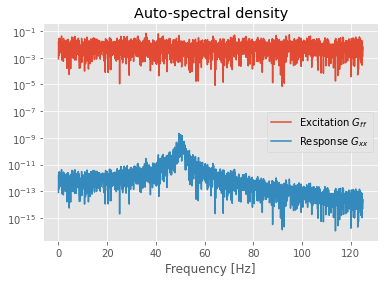

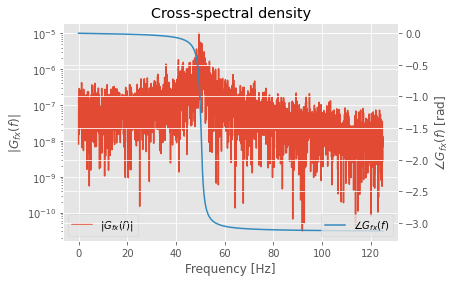

In [51]:
# Calculating the PSD and CSD for single excitation

rng = np.random.default_rng(0)
N = 5000
fs = 250
dt = 1./fs
f = rng.normal(size=N)
time = np.arange(N)*dt

F = np.fft.rfft(f)
scale = 1.0 / (fs*N)
freq = np.fft.rfftfreq(N, d=dt)
G_ff = 2*scale*np.abs(F.conj()*F) # One-sided PSD

def alpha(freq, m, k, c):
    """
    frequency transfer function of linear oscilator.
    """
    omega = 2*np.pi*freq
    return 1 / (-omega**2*m + 1j*omega*c + k)

H = alpha(freq, m=1,k=1e5,c=10)
G_xx = np.abs(H.conj()*H*G_ff)
G_fx = H*G_ff

plt.title('Auto-spectral density')
plt.semilogy(freq, G_ff, label='Excitation $G_{ff}$')
plt.semilogy(freq, G_xx, label='Response $G_{xx}$')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.set_title('Cross-spectral density')
ax.semilogy(freq, np.abs(G_fx), label='$|G_{fx}(f)|$')
ax.legend(loc=3)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('$|G_{fx}(f)|$')
ax2 = ax.twinx() 
ax2.plot(freq, np.angle(G_fx), 'C1', label='$\\angle G_{fx}(f)$')
ax2.set_ylabel('$\\angle G_{fx}(f)$ [rad]')
ax2.legend(loc=4)
plt.show()

## Multiple input

![transfer_function_MISO](./figures/transfer_function_MISO_response.svg)

The Auto-spectral density (PSD) of the response can be obtained as:

$$
S_{xx}(f)= \sum_{k=1}^{N} \sum_{l=1}^{N} H_k^\ast(f) H_l(f) S_{f_kf_l}(f),
$$

and the Cross-spectral density (CSD) as:

$$
S_{f_kx}(f)= \sum_{l=1}^{N} H_l(f) S_{f_kf_l}(f),
$$

where ${}^*$ denotes the complex conjugate.

### Example: Calculating the response PSD and CSD for a system subjected to 2 excitations

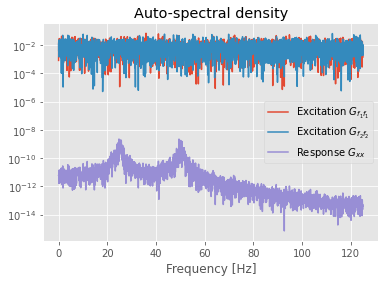

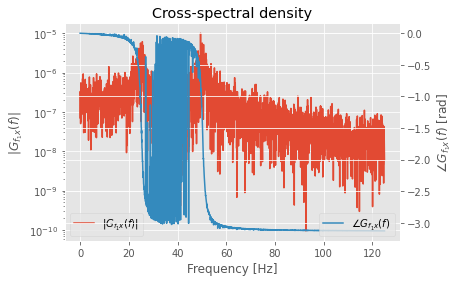

In [52]:
# Calculating the response PSD and CSD for a system subjected to 2 excitations

rng = np.random.default_rng(0)
N = 5000
fs = 250
dt = 1./fs
f1 = rng.normal(size=N)
f2 = rng.normal(size=N)
time = np.arange(N)*dt

F1 = np.fft.rfft(f1)
F2 = np.fft.rfft(f2)

scale = 1.0 / (fs*N)
freq = np.fft.rfftfreq(N, d=dt)

# Excitation PSD and CSD
G_f1f1 = 2*scale*np.abs(F1.conj()*F1)
G_f2f2 = 2*scale*np.abs(F2.conj()*F2) 
G_f1f2 = 2*scale*np.abs(F1.conj()*F2) 
G_f2f1 = 2*scale*np.abs(F2.conj()*F1)

def alpha(freq, m, k, c):
    """
    frequency transfer function of linear oscilator.
    """
    omega = 2*np.pi*freq
    return 1 / (-omega**2*m + 1j*omega*c + k)

H1 = alpha(freq, m=1,k=1e5,c=10)
H2 = alpha(freq, m=2,k=.5e5,c=20)

# Response PSD
G_xx = np.abs(H1.conj()*H1)*G_f1f1 + np.abs(H1.conj()*H2)*G_f1f2 \
    + np.abs(H2.conj()*H1)*G_f2f1 + np.abs(H2.conj()*H2)*G_f2f2

#G_xx2 = np.abs(H1.conj()*H1)*G_f1f1 + np.abs(H2.conj()*H2)*G_f2f2 # missig cross terms

# CSD; excitation-response
G_f1x = H1*G_f1f1 + H2*G_f1f2
G_f2x = H1*G_f2f1 + H2*G_f2f2

plt.title('Auto-spectral density')
plt.semilogy(freq, G_f1f1, label='Excitation $G_{f_1f_1}$')
plt.semilogy(freq, G_f2f2, label='Excitation $G_{f_2f_2}$')
plt.semilogy(freq, G_xx, label='Response $G_{xx}$')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.set_title('Cross-spectral density')
ax.semilogy(freq, np.abs(G_f1x), label='$|G_{f_1x}(f)|$')
#ax.semilogy(freq, np.abs(G_f2x), label='$|G_{f_2x}(f)|$')
ax.legend(loc=3)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('$|G_{f_1x}(f)|$')
ax2 = ax.twinx() 
ax2.plot(freq, np.angle(G_f1x), 'C1', label='$\\angle G_{f_1x}(f)$')
#ax2.plot(freq, np.angle(G_f2x), 'C1', label='$\\angle G_{f_2x}(f)$')
ax2.set_ylabel('$\\angle G_{f_1x}(f)$ [rad]')
ax2.legend(loc=4)
plt.show()

# FFT and PSD
<a id='FFT_and_PSD'></a>

Engineering processes are usually continuous and are detected with the help of various detectors that generate a physically measurable quantity, i.e. signal. The signal or time history is usually also a continuous quantity (sometimes we will also hear an analog quantity). Due to the processing of the data with a computer, these continuous quantities are discretized. Usually, such discretization is done with a constant time step. The figure below shows the continuous and discrete time series. In general, we are not talking about signals or time series, but about data.

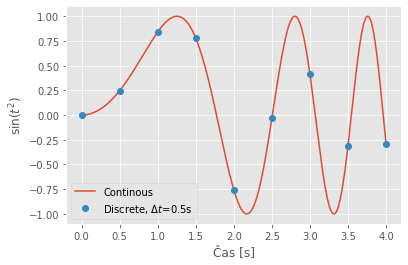

In [53]:
# Discretization of continous data
# (we cannot actually generate a continuous time series on a computer; "continuous" is just much denser)
t, dt = np.linspace(0,4,1000, retstep=True)
t2, dt2 = np.linspace(0,4,9, retstep=True)

plt.plot(t, np.sin(t**2), label='Continous') 
plt.plot(t2, np.sin(t2**2), 'o',label='Discrete, $\\Delta t$=0.5s')
plt.xlabel('Čas [s]')
plt.ylabel('$\\sin(t^2)$')
plt.grid(True)
plt.legend()
plt.show()

## Sampling

So far we have dealt with continuous data $x(t)$, but in experimental work we almost always encounter discrete values that are typically covered by a uniform time sampling $x(n\,\Delta t)$, where $\Delta t $ **sampling time (period)** ($f_s=1/\Delta t$ is **sampling frequency**).

In understanding sampled data, we help ourselves with *ideal uniformly sampled data* $x_s(t)$, which is the product of continuous data $x(t)$ and a train of pulses $i(t)$:

![sampling](./figures/sampling.svg)

$$
x_s(t)=x(t)\,i(t),
$$

where:

$$
i(t)= \sum_{n=-\infty}^{+\infty}\delta(t-n\,\Delta t)
$$

![sampling_all](./figures/sampling_all.svg)

## Aliasing

Discretization of data modifies the frequency content $X(f)$ of the continuous data $x(t)$. Let's look at the details: the train of pulses $i(t)$ can be seen as periodic data with a period $\Delta t$ and described by a Fourier series:

$$
i(t)= \sum_{n=-\infty}^{+\infty}\delta(t-n\,\Delta t) = \sum_{n=-\infty}^{+\infty}c_n\,e^{\textrm{i}\,2\pi\,n\,t/\Delta t}
$$

where:

$$
c_n=\frac{1}{\Delta t}\,\int_{-\Delta t/2}^{+\Delta t/2}i(t)\,e^{-\textrm{i}\,2\pi\,n\,t/\Delta t}\,\textrm{d}t=\frac{1}{\Delta t}
$$

From this follows:

$$
i(t)= \frac{1}{\Delta t}\, \sum_{n=-\infty}^{+\infty}e^{\textrm{i}\,2\pi\,n\,t/\Delta t}
$$


We introduce the Fourier transform of a sequence as

$$
\begin{split}
X_{\mathrm{s}}(f)=&\mathcal{F}\left\{x(t)\,i(t)\right\}= \mathcal{F}\left\{x(t)\,
\frac{1}{\Delta t}\sum_{n=-\infty}^{\infty} \mathrm{e}^{\mathrm{j}\,2\pi\,n\,t / \Delta t}\right\} = 
\frac{1}{\Delta t}\sum_{n=-\infty}^{\infty}\mathcal{F}\left\{x(t)\,\mathrm{e}^{\mathrm{j}\,2\pi\,n\,t/\Delta t}\right\}\\
=&\frac{1}{\Delta t}\sum_{n=-\infty}^{\infty} X\left(f-\frac{n}{\Delta t}\right)
\end{split}
$$

Evidently, the Fourier transform of the sequence $x_s(t)$ is the sum of shifted versions (aliases) of the Fourier transform of the underlying continuous signal.

### Example: aliasing

Time sampling and frequency overlap will be looked at here using the example of a Gaussian window, which is defined in the time and frequency domains as:

$$
x(t) = e^{-a\,t^2},\quad X(f)=\sqrt{\frac{\pi}{a}}\, e^{-\pi^{2}\,f^{2}/a};\qquad a>0 
$$

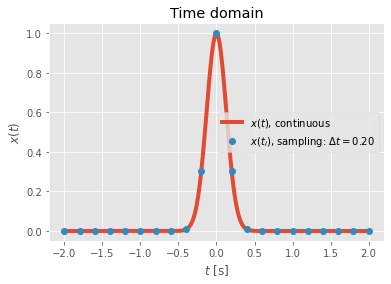

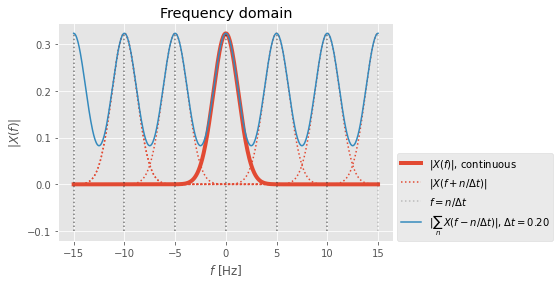

In [54]:
# aliasing

t, f = sym.symbols('t, f', real=True)
n, Δt = sym.symbols('n, Δt')
a = sym.symbols('a', real=True, positive=True)
x = sym.exp(-a*t**2)
X = sym.fourier_transform(x, t, f)
Xsum = sym.Sum(X.subs(f, f-n/Δt), (n, -10, 10))

data = {a: 30, Δt: .2} # instruction: change parameters value
# vectorized functions for numpy
f_x = sym.lambdify(t, x.subs(data), 'numpy')
f_X_abs = sym.lambdify(f, sym.Abs(X.subs(data)), 'numpy')
f_Xsum_abs = sym.lambdify(f, sym.Abs(Xsum.subs(data)), 'numpy')

N = int(2/data[Δt]) # time in interval [-2,2]
t_g = np.arange(-10*N,10*N+1)*data[Δt]/10 # for continuous function
n = np.arange(-N,N+1) 
t_i = n*data[Δt]
K = 3 # number of adjacent aliases X(f)
fr = np.linspace(-K/data[Δt],K/data[Δt], num=500)

plt.title('Time domain')
plt.plot(t_g, f_x(t_g), 'C0', label='$x(t)$, continuous', linewidth=4)
plt.plot(t_i, f_x(t_i), color='C1', marker='o', ls='', label=f'$x(t_i)$, sampling: $\\Delta t=${data[Δt]:3.2f}')
plt.xlabel('$t$ [s]')
plt.ylabel('$x(t)$')
plt.legend()
plt.show()

plt.title('Frequency domain')
plt.plot(fr, f_X_abs(fr), 'C0', label='$|X(f)|$, continuous', linewidth=4)
for i in range(-K,K):
    plt.plot(fr, f_X_abs(fr+i/data[Δt]), 'C0', ls=':')
    plt.vlines(i/data[Δt], -0.1, np.max(f_X_abs(fr)), 'k', ls=':', alpha=0.5)
plt.plot(fr, f_X_abs(fr+i/data[Δt]), 'C0', ls=':', label='$|X(f+n/\Delta t)|$')
plt.vlines((i+1)/data[Δt], -0.1, np.max(f_X_abs(fr)), 'k', ls=':', alpha=0.2, label='$f=n/\Delta t$')
plt.plot(fr, f_Xsum_abs(fr), color='C1', label=f'$|\sum_n\,X(f-n/\Delta t)|$, $\\Delta t=${data[Δt]:3.2f}')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$|X(f)|$')
plt.legend(loc=(1.01,0))
plt.show()

##  Anti-aliasing filters

To avoid aliasing the signal must be band-limited; it must not have any frequency
component above a certain frequency, say $f_\mathrm{max}$, and the sampling rate must be chosen to
be greater than twice the highest frequency contained in the signal, namely

$$
f_\mathrm{s} > 2 f_\mathrm{max}
$$

We shall assume that the anti-aliasing filter operates on the signal $x(t)$ to produce a
signal to be digitized as:

![AA_filter_signal](./figures/AA_filter_signal.svg)

But we still need to decide what the highest frequency $f_\mathrm{max}$ is just prior to the ADC (analogue-to-digital converter). The critical features in deciding this are:
 
- the ‘cut-off’ frequency of the filter $f_c$, usually the $f_c$ (Hz) = 3 dB point of the filter
- the ‘roll-off rate’ of the filter in dB/octave

![AA_filter_characteristics](./figures/AA_filter_characteristics.svg)

### Example: Low-pass filtering

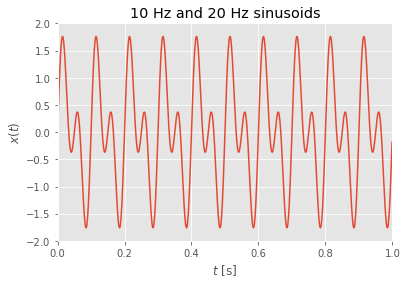

In [55]:
# Low-pass filtering; signal definition
t = np.linspace(0, 1, 1000, False)  # 1 second
fs = 1000
dt=1/fs
t = np.arange(0, 1, dt)# 1 second
f1 = 10
f2 = 20
sig = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)

plt.plot(t, sig)
plt.title('10 Hz and 20 Hz sinusoids')
plt.axis([0, 1, -2, 2])
plt.xlabel('$t$ [s]')
plt.ylabel('$x(t)$');

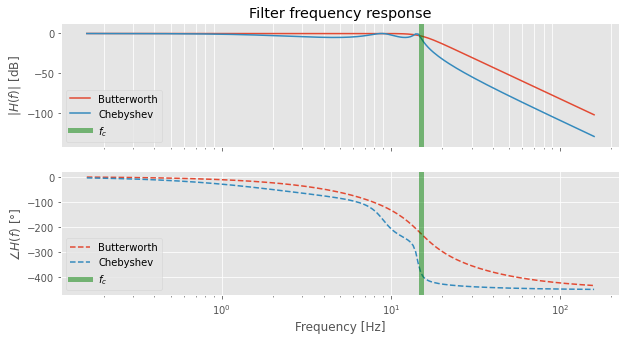

In [56]:
# Low-pass filtering, filters
fs = 1000
fc = 15 # Hz
order = 5

#analog filters
b, a = signal.butter(order, fc*np.pi*2, 'low', analog=True) 
w_b, h_b = signal.freqs(b, a)
b, a = signal.cheby1(order, 5, fc*np.pi*2, 'low', analog=True)
w_c, h_c = signal.freqs(b, a)

fig, (ax1, ax2)  = plt.subplots(2,1, figsize=(10,5), sharex=True)
ax1.set_title('Filter frequency response')
ax1.semilogx(w_b/(2*np.pi), 20 * np.log10(abs(h_b)), label='Butterworth')
ax1.semilogx(w_c/(2*np.pi), 20 * np.log10(abs(h_c)), label='Chebyshev')
ax1.set_ylabel('$|H(f)|$ [dB]')
ax1.margins(0, 0.1)
ax1.grid(which='both', axis='both')
ax1.axvline(fc, color='green', lw=5, alpha=.5,  label='$f_c$')
ax1.legend(loc='lower left')

ax2.semilogx(w_b/(2*np.pi), np.unwrap(np.angle(h_b)) * 180/np.pi , '--', label='Butterworth')
ax2.semilogx(w_c/(2*np.pi), np.unwrap(np.angle(h_c)) * 180/np.pi , '--', label='Chebyshev')
ax2.set_ylabel('$\\angle H(f)$ [°]')
ax2.set_xlabel('Frequency [Hz]')
ax2.axvline(fc, color='green', lw=5, alpha=.5,  label='$f_c$')

ax2.legend(loc='lower left')

plt.show()

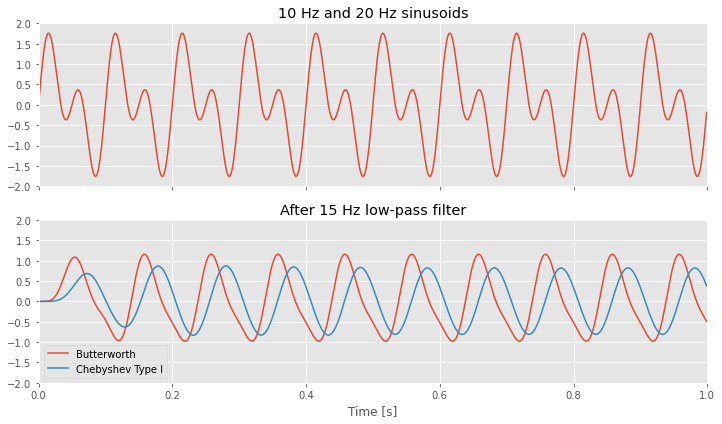

In [57]:
# Low-pass filtering, filtered signals

sos_b = signal.butter(order, fc, 'lowpass', fs=fs, output='sos') #digital filter
sos_c = signal.cheby1(order, 5, fc, 'lowpass', fs=fs, output='sos')

filtered_b = signal.sosfilt(sos_b, sig)
filtered_c = signal.sosfilt(sos_c, sig)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])

ax2.plot(t, filtered_b, label='Butterworth')
ax2.plot(t, filtered_c,  label='Chebyshev Type I')
ax2.set_title('After 15 Hz low-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [s]')
ax2.legend(loc='lower left')

plt.tight_layout()
plt.legend(loc='lower left')
plt.show()

##  Analogue-to-digital conversion and dynamic range

An ADC is a device that takes a continuous (analogue) time signal as an input and produces
a sequence of numbers (digital) as an output that are sample values of the input. It may be
convenient to consider the ADC process as consisting of two phases, namely sampling and
quantization

![SH_AD_converter](./figures/SH_AD_converter.svg)

The presentation of numbers in a computer is of finite precision, typically today's computers use 64-bit recording accuracy, which is significantly more than the accuracy of recording measuring cards. Let's look here at the example of the sinusoid below, which is quantized in two ranges ([-1, 1] and [-5, 5]) with 4-bit precision (16 levels). If we use a 24-bit card and a typical measurement range [-10, 10], the difference between the two quantization levels is about 1e-6, which is quite enough for most measurements. If we use a system with a lower dynamic range, we must pay close attention to the measurement area in connection with the dynamic range and possibly amplify the measured data. When measuring, you should also pay attention to clipping when the measurement range is too small (example below: [-0.5, 0.5]).

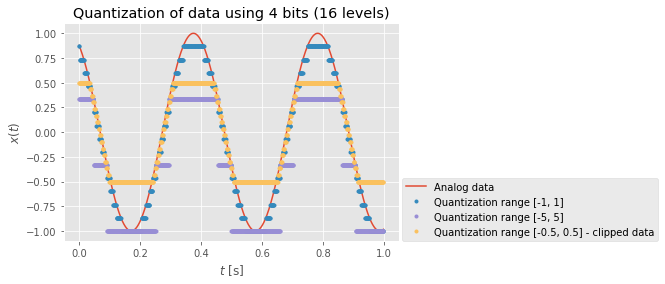

In [58]:
# Quantization of data using 4 bits  
T = 1
N = 1000
fr = 2.452
t, dt = np.linspace(0, T, N, endpoint=False, retstep=True)
angle = 0.5
x = 1*np.cos(2*np.pi*fr*t+angle)

def get_quantized(x, bits = 4, adc_range = (-2, 2)):
    x2 = x.copy()
    lo, hi = adc_range
    x2[x<=lo] = lo
    x2[x>=hi] = hi
    delta = (hi - lo) / (2**(bits)-1)
    qnt = lo+delta*np.floor((x2-lo)/delta)
    return qnt

bits = 4
levels = 2**bits
x2 = get_quantized(x, bits = bits, adc_range=(-1, 1))
x3 = get_quantized(x, bits = bits, adc_range=(-5, 5))
x4 = get_quantized(x, bits = bits, adc_range=(-.5, .5))

plt.title(f'Quantization of data using {bits} bits ({levels} levels)')
plt.plot(t, x, 'C0', label='Analog data')
plt.plot(t, x2, 'C1', marker='.', linestyle='', label=f'Quantization range [-1, 1]')
plt.plot(t, x3, 'C2', marker='.', linestyle='', label=f'Quantization range [-5, 5]')
plt.plot(t, x4, 'C4', marker='.', linestyle='', label=f'Quantization range [-0.5, 0.5] - clipped data')
plt.xlabel('$t$ [s]')
plt.ylabel('$x(t)$')
plt.legend(loc=(1.01,0))
plt.show()

In the above example the steps are uniform and the quantization error can be expressed as:

$$
e(n \Delta) = \tilde{x}(n \Delta) - x (n \Delta)
$$

The difference between the quantized value and the actual value can be considered as a random noise $e$ with a uniform distribution within the quantization step $\delta$

![uniform_pdf_quantization_error](./figures/uniform_pdf_quantization_error.svg)

The variance of such noise is defined as:

$$
\mathrm{Var}\,(e) = \sigma_e^2 =  E[(e-\mu_e)^2]= \int_{-\infty}^{\infty} (e - \mu_e)^2\,p(e)\,\mathrm{d}e = \frac{1}{\delta}  \int_{-\delta / 2}^{\delta /2} e^2 \,\mathrm{d}e  = \frac{\delta^2}{12} = \frac{(A/2^b)^2}{12},
$$

where $A$ is the full span of the quantization region and $b$ is the number of quantization bits, excluding the sign bit.



The dynamic range (or quantization signal-to-noise ratio) of the ADC is given as:

$$
\textrm{SNR}=10\log_{10}\left(\frac{\mathrm{signal\, power}}{\mathrm{error\, power}}\right) = 10\log_{10}\left(\frac{\sigma_x^2}{\sigma_e^2}\right)
$$

where $\sigma_x^2$ and $\sigma_e^2$ represent the power of useful information (*signal* $x$) and noise ($e$).

## Discrete Fourier transform (DFT) 

Fourier transform of sequence:

$$
X_{\mathrm{s}}(f)=\mathcal{F}\left\{x(t)\,i(t)\right\}=\frac{1}{\Delta t}\sum_{n=-\infty}^{\infty} X\left(f-\frac{n}{\Delta t}\right)
$$

Alternative form: 

$$
\begin{split}
X_{\mathrm{s}}(f)&=\mathcal{F}\left\{x(t)\,i(t)\right\}=\int_{-\infty}^{+\infty}\left[ x(t)\,\sum_{n=-\infty}^{+\infty}\delta(t-n\,\Delta t) \right]\,e^{-\textrm{i}\,2\pi\,f\,t}\,\textrm{d} t,\\
&=\sum_{n=-\infty}^{+\infty}\,\int_{-\infty}^{+\infty} x(t)\,e^{-\textrm{i}\,2\pi\,f\,t}\,\delta(t-n\,\Delta t)\,\textrm{d} t,\\
&=\sum_{n=-\infty}^{+\infty}\,x(n\,\Delta t)\,e^{-\textrm{i}\,2\pi\,f\,n\,\Delta t}
\end{split}
$$

For sequence of length $N$, $n=0,1,...,N-1$:
$$
\begin{split}
X_s(f)=\sum_{n=0}^{N-1}\,x(n\,\Delta t)\,e^{-\textrm{i}\,2\pi\,f\,n\,\Delta t}
\end{split}
$$

Note that this is still continuous in frequency. Now, let us evaluate this at frequencies $f = k/(N\,\Delta t)$:

$$
X_k = \sum_{n=0}^{N-1} x_n\,e^{-\mathrm{i}\,\left(2\pi\,/\,N\right)\,n\,k},
$$

where $x_n = x(n\,\Delta t)$ and $k$ is integer. This is DFT of a finite sequence $x(n\,\Delta t)$.

**Inverse DFT**:

$$
x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k\,e^{\mathrm{i}\,\left(2\pi\, /\, N\right)\,n\,k}.
$$


## Fast Fourier Transform (FFT)

Fast Fourier transform (FFT) is the name of a numerical algorithm for discrete Fourier transform. DFT has a numerical range proportional to $N^2$, which is written as: ($\mathcal{O}(N^2)$). The authors of the fast Fourier transform are James Cooley and John Tukey, who published the algorithm in 1965 (see: [source](https://www.ams.org/journals/mcom/1965-19-090/S0025-5718-1965-0178586-1/S0025-5718-1965-0178586-1.pdf)), but it later turned out that a similar algorithm had been discovered much earlier, in an unpublished work from 1805, by Carl Friedrich Gauss. The algorithm has this essential property that it is significantly faster numerically: $\mathcal{O}(N\log(N))$; since the numerical range no longer increases quadratically with the number of elements, this has significantly increased the utility of the DFT, and the FFT algorithm is considered by some to be one of the most important algorithms since it had and continues to have a very significant socio-economic impact. As an interesting point, we can say here that the algorithm was not patented (see: [source](https://en.wikipedia.org/wiki/Fast_Fourier_transform)). Due to the symmetry in the data, the calculation speed is the highest if the number of samples is equal to $2^n$, where $n\in\mathbb{Z}$.

### Example: FFT of two sinusoids

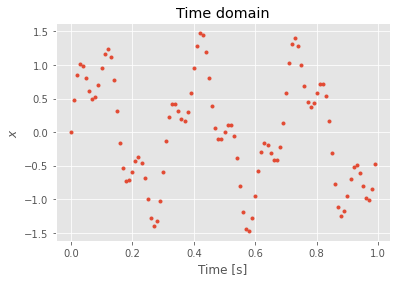

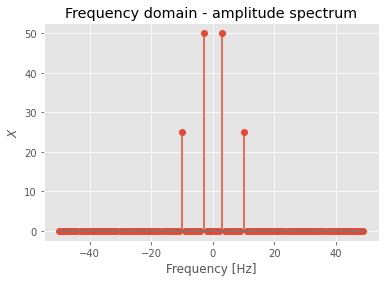

In [59]:
#  FFT of two sinusoids
A1, A2 = 1, 0.5
fr1, fr2 = 3, 10
fs = 100
N = 100
dt = 1/fs
t = np.arange(N)*dt
x = A1*np.sin(2*np.pi*fr1*t) + A2*np.sin(2*np.pi*fr2*t)

X = np.fft.fft(x)
freq = np.fft.fftfreq(len(x), d=dt)

plt.title('Time domain')
plt.plot(t, x, '.')
plt.xlabel('Time [s]')
plt.ylabel('$x$')
plt.show()

plt.title('Frequency domain - amplitude spectrum')
plt.stem(freq, np.abs(X), '.')
plt.xlabel('Frequency [Hz]')
plt.ylabel('$X$')
plt.show()

## DFT coefficients - Fourier series relation

Discrete Fourier transform is closely related to Fourier series. We can quickly reveal the connection if we assume a discrete time series $x_i=x(\Delta t\,i)$ where $\Delta t$ is a constant time step, $i=0,1,\dots,N-1$ and $T_p=N\,\Delta t$, follows:

$$
\begin{split}
c_k &= \frac{1}{T_p}\,\int_0^{T_p} x(t)\,e^{-\mathrm{i}\,2\pi\,k\,t/T_p}\,\mathrm{d}t\\
&= \frac{1}{N\,\Delta t}\,\sum_{n=0}^{N-1} x(n\,\Delta t)\,e^{-\mathrm{i}\,2\pi\,k\,\Delta t\,n/(N\,\Delta t)}\,\Delta t\\
&= \frac{1}{N}\,\underbrace{\sum_{n=0}^{N-1} x(n\,\Delta t)\,e^{-\mathrm{i}\,2\pi\,k\,n/N}}_{X_k}\\
&= \frac{X_k}{N}\\
\end{split}
$$



###  Example: DFT coefficients - Fourier series relation

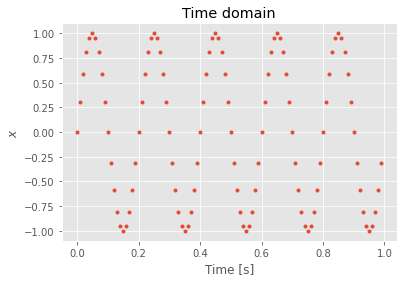

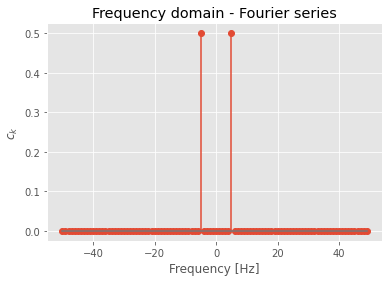

In [60]:
#  DFT coefficients - Fourier series relation
A = 1
fr = 5
fs = 100
N = 100
dt = 1/fs
t = np.arange(N)*dt
x = A*np.sin(2*np.pi*fr*t)

X = np.fft.fft(x)
c_k = X/N
freq = np.fft.fftfreq(N, d=dt)

plt.title('Time domain')
plt.plot(t, x, '.')
plt.xlabel('Time [s]')
plt.ylabel('$x$')
plt.show()

plt.title('Frequency domain - Fourier series')
plt.stem(freq, np.abs(X)/N, '.')
plt.xlabel('Frequency [Hz]')
plt.ylabel('$c_k$')
plt.show()

## Frequency resolution and zero-padding

The frequency resolution of the DFT is defined by the length of the discrete time series $x_i=x(\Delta t\,i)$, where $\Delta t$ is a constant time step, $i=0,1,\dots,N-1$; the length of such a type is therefore $T_p=N\,\Delta t$, so it follows that the frequency resolution is:

$$
\Delta f= \frac{1}{N\,\Delta t}.
$$

With a longer time series a better frequency resolution could be obtained. When additional points of the discrete type cannot be obtained, the frequency resolution can be increased by zero-padding:

$$
\tilde{x}_n=
\begin{cases}
x_n;\quad & 0\le n\le N-1\\
0;\quad & N\le n\le L-1
\end{cases}
$$

**Discrete Fourier transform with zero-padding**

$$
\tilde{X}_k = \sum_{n=0}^{L-1} \tilde{x}_n\,e^{-\mathrm{i}\,2\pi\,k\,n/L}
= \sum_{n=0}^{N-1} x_n\,e^{-\mathrm{i}\,2\pi\,k\,n/L}
$$


The frequency resolution is:

$$
\Delta f = \frac{1}{L\,\Delta t}
$$

However, it should be emphasized that it is only a frequency interpolation, which allows us a more detailed insight; we do not add new information by adding zeros. Similar to the DFT, we can add zeros in the frequency domain and then use the inverse discrete Fourier transform to obtain more dense or interpolated time data.

### Example: Frequency resolution and zero-padding

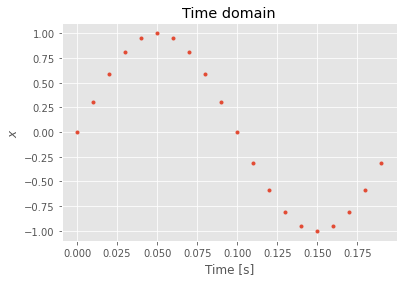

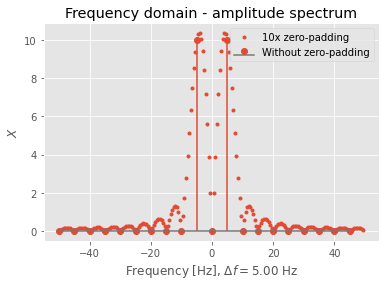

In [61]:
# Frequency resolution and zero-padding
A = 1
fr = 5
fs = 100 
N = 20 # here try 20 (data for 1 sinosoid); the result without zero-padding is correct!)
k = 10 # zero-padding
dt = 1/fs
t = np.arange(N)*dt
x = A*np.sin(2*np.pi*fr*t)

X = np.fft.fft(x)
freq = np.fft.fftfreq(N, d=dt)

X_kx = np.fft.fft(x, n=k*N)
freq_kx = np.fft.fftfreq(k*N, d=dt)

plt.title('Time domain')
plt.plot(t, x, '.')
plt.xlabel('Time [s]')
plt.ylabel('$x$')
plt.show()

plt.title('Frequency domain - amplitude spectrum')
plt.plot(freq_kx, np.abs(X_kx), '.', label=f'{k}x zero-padding')
plt.stem(freq, np.abs(X), label='Without zero-padding')
plt.xlabel(f'Frequency [Hz], $\Delta f=${1/(N*dt):3.2f} Hz')
plt.ylabel('$X$')
plt.legend()
plt.show()

## The effect of data truncation

Suppose that we want to calculate the Fourier transform of a deterministic signal $x(t)$, which is defined in principle from $-\infty$ to $+\infty$, but we observe the signal in the range from $-T/2$ to $+ T/$2:

$$
x_T(t)=x(t)\,w(t),
$$

where the window function $w(t)$ is defined as:

$$
w(t)=
\begin{cases}
1;\quad\textrm{if}\quad |t|\le T/2\\
0;\quad\textrm{else}.
\end{cases}
$$

![windowing_time](./figures/windowing_time.svg)

If we obtain the Fourier transform $x_T(t)$ the following applies:

$$
X_T(t)=\mathcal{F}\{x(t)\,w(t)\}= X(f)*W(f)=\int_{-\infty}^{+\infty} X( g)\,W(f-g)\,\textrm{d}g
$$

So the message is: $X(f)$ represents the frequency transform of the function $x(t)$, which can only be viewed in a time-limited window $w(t)$, and this causes the Fourier transform to be distorted. The frequency transform of the rectangular pulse $w(t)$ is defined as:

$$
W(f)=T\,\frac{\sin\left(\pi\,T\,f \right)}{\pi\,T\,f }
$$

![windowing_freq](./figures/windowing_freq.svg)

### Example: sinusoidal signal 

Consider a sinusoidal signal

$$
x(t) = cos(2 \pi \, p \,t)
$$

whose Fourier transform is

$$
X_{\mathrm{T}}(f)=\frac{1}{2}\int_{-\infty}^{\infty}\left(\delta\left(g+p\right)+\delta \left(g-p\right)\right)W(f-g)\,\mathrm{d}g=\frac{1}{2}\left(W\left(f+p\right)+W\left(f-p\right)\right).
$$

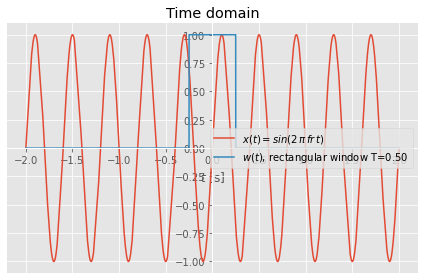

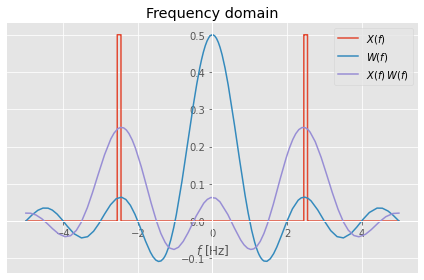

In [62]:
# windowing, sinusoidal
t, f, τ, fr, T = sym.symbols('t, f, τ, fr, T', real=True)
i = sym.I
π = sym.pi

parameters = {fr: 2.5, T: 0.5}

x = sym.sin(2*π*fr*t)
w = sym.Heaviside(t+T/2) - sym.Heaviside(t-T/2)

xw = x*w
X = 1/2 * sym.DiracDelta(f+fr) + 1/2 * sym.DiracDelta(f-fr)
W = T / (π*f) * sym.sin(π*f)


XW = sym.integrate(X.subs(f,τ)*W.subs(f,f-τ), (τ, -sym.oo, +sym.oo)) # convolution in the frequency domain

p1 = sym.plot(x.subs(parameters), (t, -2, +2), line_color='C0', 
              label=f'$x(t)=sin(2\,\pi\,fr\,t)$', show=False,
              title='Time domain', ylabel='', xlabel='$t$ [s]')
p2 = sym.plot(w.subs(parameters), (t, -2, +2), line_color='C1', 
              label=f'$w(t)$, rectangular window T={T.subs(parameters):3.2f}', show=False)
p1.extend(p2)
p1.legend = True
p1.show()

p1 = sym.plot(0.5*(sym.Heaviside(f+(fr+0.05))-sym.Heaviside(f+(fr-0.05))+
                   sym.Heaviside(f-(fr-0.05))-sym.Heaviside(f-(fr+0.05))).subs(parameters), 
              (f, -5, +5), line_color='C0', 
              label=f'$X(f)$', show=False,
              title='Frequency domain', ylabel='', xlabel='$f$ [Hz]')
p2 = sym.plot(W.subs(parameters), (f, -5, +5), line_color='C1', 
              label=f'$W(f)$', show=False)
p3 = sym.plot(XW.subs(parameters), (f, -5, +5), line_color='C2', 
              label=f'$X(f)\,W(f)$', show=False)
p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()

Window ‘carpentry’ is used to design windows to reduce leakage at the expense of
main lobe width in Fourier transform calculations, i.e. to obtain windows with small side
lobes. One ‘trades’ the side lobe reduction for ‘bandwidth’, i.e. by tapering the window
smoothly to zero, the side lobes are greatly reduced, but the price paid is a much wider
main lobe. The frequency characteristic of a window is often presented in dB normalized
to unity gain (0 dB) at zero frequency.

![windowing_freq_characteristics](./figures/windowing_freq_characteristics.svg)

### Example: Window characteristics

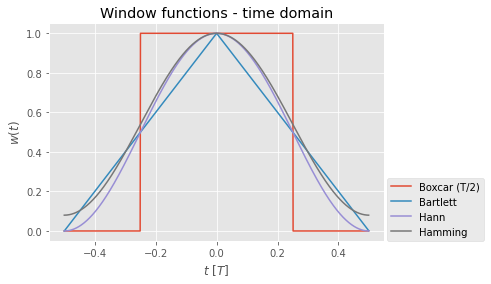

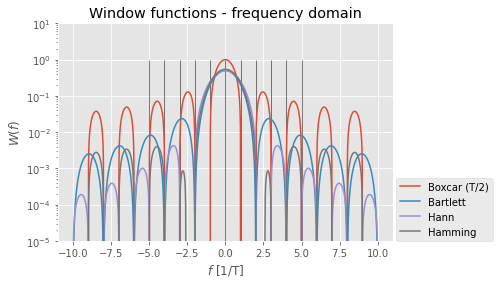

In [63]:
# window functions for filtering and spectral estimation
A = 1 # amplitude 
T = 1. # window length
N = 1000
t = np.linspace(-T/2, T/2, N, endpoint=False)
dt = t[1] - t[0]

# rectangular 
wp = np.ones_like(t)
Tp = T/2 # simulated width is T/2
wp[np.abs(t)>Tp/2] = 0
fT_theor = np.arange(-10,10,0.01)
Wp_theor = A*T / (np.pi*fT_theor) * np.sin(np.pi*fT_theor)

#Bartlett
wBartlett = np.ones_like(t)
wBartlett = A*(wBartlett-np.abs(t)/(T/2))
WBartlett_theor = 0.5*A*T * np.power(np.sin(0.5*np.pi*fT_theor) / (0.5*np.pi*fT_theor),2)

#Hann
wHann = A*np.power(np.cos(np.pi*t/T), 2)
WHann_theor = 0.5*A*T * np.sin(np.pi*fT_theor) / (np.pi*fT_theor*(1-fT_theor**2))

#Hamming
wHamming = 0.54+0.46*np.cos(2*np.pi*t/T)
WHamming_theor = (0.54*np.pi**2-0.08*(np.pi*fT_theor)**2)*np.sin(np.pi*fT_theor)/(np.pi*fT_theor*(np.pi**2-(np.pi*fT_theor)**2))

plt.plot(t,wp,'C0', label='Boxcar (T/2)')
plt.plot(t,wBartlett,'C1', label='Bartlett')
plt.plot(t,wHann,'C2', label='Hann')
plt.plot(t,wHamming,'C3', label='Hamming')
plt.title('Window functions - time domain')
plt.xlabel('$t$ [$T$]')
plt.ylabel('$w(t)$')
plt.legend(loc=(1.01, 0));
plt.show()

draw = plt.plot
draw = plt.semilogy # ylim needs to be adjusted
plt.vlines(np.arange(-5,6), 0,1, 'k', lw=1, alpha=0.5)
draw(fT_theor, Wp_theor, 'C0', label='Boxcar (T/2)')
draw(fT_theor, WBartlett_theor, 'C1', label='Bartlett')
draw(fT_theor, WHann_theor, 'C2', label='Hann')
draw(fT_theor, WHamming_theor, 'C3', label='Hamming')
#plt.xlim(-5,5)
plt.ylim(1e-5, 1e1)
plt.title('Window functions - frequency domain')
plt.xlabel('$f$ [1/T]')
plt.ylabel('$W(f)$')
plt.legend(loc=(1.01, 0));

# Calculating PSD From Time Signals
<a id='Calculating_PSD_From_Time_Signals'></a>

![PSD_estimation_tree](./figures/PSD_estimation_tree.svg)

## Segment averaging

The segment averaging method has become very popular mainly because of its fast speed of computation. Consider the data (length $T_p$) which is segmented into $q$ separate time slices each of length $T_r$ such that $q\,T_r = T_p$ (in this case non-overlapping).

![PSD_estimation_segment_averaging](./figures/PSD_estimation_segment_averaging.svg)

Now we form the raw periodogram for each slice as:

$$
\tilde{S}_{xx,i}(f) = \frac{1}{T_r}\left|X^*_{T_{ri}}(f)\,X_{T_{ri}}(f)\right|,\\
\tilde{S}_{xy,i}(f) = \frac{1}{T_r}\left|X^*_{T_{ri}}(f)\,Y_{T_{ri}}(f)\right|
$$

By averaging successive raw spectra the variability of estimate reduces:

$$
\tilde{S}_{xx}(f) = \frac{1}{q}\sum_{i=1}^{q}\tilde{S}_{xx,i}(f),\\
\tilde{S}_{xy}(f) = \frac{1}{q}\sum_{i=1}^{q}\tilde{S}_{xy,i}(f)
$$

### Welch transform

Since the use of a rectangular data window introduces leakage, the basic method above is usually modified by using other data windows. However, since the windows have tapering ends, the values obtained for $\tilde{S}_{xx,i}(f)$ must be compensated for
the ‘power reduction’ introduced by the window. This results in the calculation of ‘modified’
periodograms for each segment in the form:

$$
\tilde{S}_{xx,i}(f) = \frac{\frac{1}{T_r}\left|\int_{i\mathrm{th\,interval}} x(t)\,w(t)\,\mathrm{e}^{-\mathrm{j} 2 pi f t}\,\mathrm{d}t\right|^2}{\frac{1}{T_r} \int_{-T_r/2}^{T_r/2} w^2(t)\,\mathrm{d}t}
$$

### Example: PSD estimation for real data

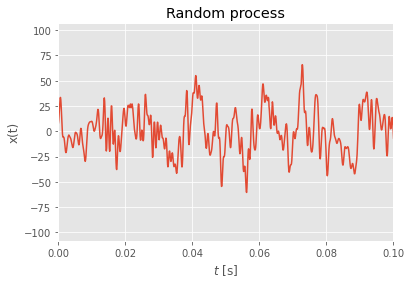

In [64]:
# Get real data, contaminated with noise
data = np.load(os.path.join('.\\data\\m1.npy'))

time = data[::2][: int(3e6 + 1)] # time , 300 s
time_history = data[1::2][: int(3e6 + 1)] # time_history

dt = time[1] - time[0]
fs = 1/dt
N = len(time_history)

plt.title('Random process')
plt.plot(time, time_history)
plt.xlabel('$t$ [s]')
plt.ylabel('x(t)')
plt.xlim(0,0.1)
plt.show()

In [65]:
# 2) DFT coefficients
X = np.fft.rfft(time_history)
freq_fft = np.fft.rfftfreq(N, d=dt)

PSD estimate can be obtained from the DFT coefficients, based on the Parseval theorem:

$$
\frac{1}{T_p}\int_0^{T_p}x^2(t)\,\textrm{d}t=
\sum_{k} |c_k|^2=
\sum_{k} S_{xx}(k\, \Delta f)\, \Delta f
$$

with the Fourier series being related to the DFT coefficients as $c_k=X_k/N$, where $N$ is the number of discrete points.

![ParsevalTheorem_FT_DFT](./figures/ParsevalTheorem_FT_DFT.svg)

Thus we can express $S_{xx}(k\, \Delta f)$ as

$$
S_{xx}(k\, \Delta f) = \frac{1}{\Delta f} |c_k|^2 = \frac{1}{ N^2\, \Delta f} |X_k|^2 = \frac{T}{ N^2} |X_k|^2 = \frac{\Delta t}{ N} |X_k|^2
$$

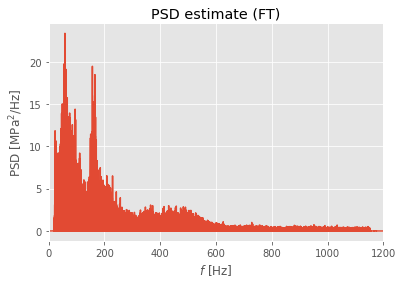

In [66]:
# PSD estimate based on FT
PSD_fft = 2* np.abs(X)**2 * dt / N # one sided PSD

plt.title('PSD estimate (FT)')
plt.plot(freq_fft, PSD_fft)
plt.xlabel('$f$ [Hz]')
plt.ylabel('PSD [$\mathrm{MPa^2/Hz}$]')
plt.xlim(0,1200)
plt.show()

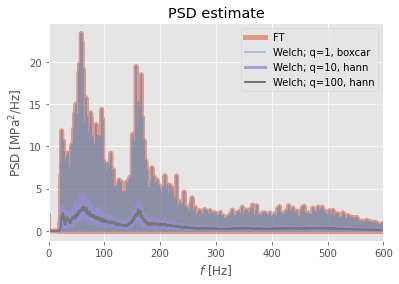

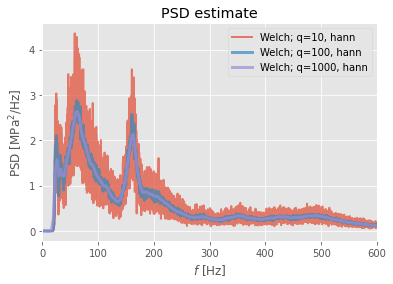

In [67]:
# PSD estimate based on the Welch transform
window = 'hann'

f_q1, Pxx_q1 = signal.welch(time_history, fs=fs, window='boxcar', nperseg=N) # same as FT
f_q10, Pxx_q10 = signal.welch(time_history, fs=fs, window=window, nperseg=N/10)
f_q100, Pxx_q100 = signal.welch(time_history, fs=fs, window=window, nperseg=N/100)
f_q1000, Pxx_q1000 = signal.welch(time_history, fs=fs, window=window, nperseg=N/1000)

plt.title('PSD estimate')
plt.plot(freq_fft, PSD_fft, lw=5, alpha=.5, label='FT')
plt.plot(f_q1, Pxx_q1, alpha=.5, label='Welch; q=1, boxcar')
plt.plot(f_q10, Pxx_q10, lw=3, alpha=.8, label=f'Welch; q=10, {window:s}')
plt.plot(f_q100, Pxx_q100, lw=2, alpha=1, label=f'Welch; q=100, {window:s}')
plt.xlabel('$f$ [Hz]')
plt.ylabel('PSD [$\mathrm{MPa^2/Hz}$]')
plt.xlim(0,600)
plt.legend()
plt.show()

plt.title('PSD estimate')
plt.plot(f_q10, Pxx_q10, lw=2, alpha=.7, label=f'Welch; q=10, {window:s}')
plt.plot(f_q100, Pxx_q100, lw=3, alpha=.7, label=f'Welch; q=100, {window:s}')
plt.plot(f_q1000, Pxx_q1000, lw=3, alpha=.7, label=f'Welch; q=1000, {window:s}')
plt.xlabel('$f$ [Hz]')
plt.ylabel('PSD [$\mathrm{MPa^2/Hz}$]')
plt.xlim(0,600)
plt.legend()
plt.show()

# Interested in Open-source and more?

http://lab.fs.uni-lj.si/ladisk/OpenSDconference.php

<img src="figures/OpenSD2023_banner.png">